In [1]:
import sys
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from datetime import date
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split


import pickle
import joblib
import time
import math
import timeit
print(os.getcwd())

D:\SAE-LSTM-ROM


In [2]:
#Split the data into two parts for training and prediction validation
import math
import joblib
training_data_whole = joblib.load(open('./data/case1data/original_data.pkl', 'rb'))
print(training_data_whole.shape)

two_dimension_data_0=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[0:4601]
two_dimension_data_2=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[4601:5001]

print(two_dimension_data_0.shape)
print(two_dimension_data_2.shape)

(6002, 84180, 2)
(4601, 168360)
(400, 168360)


In [4]:
#Using the POD to study the code length correspoonding with percentage of energy captured
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90, svd_solver='full')
pca.fit(two_dimension_data_0)
print(pca.explained_variance_ratio_)
pca_data=pca.transform(two_dimension_data_0)
print(pca_data.shape)

[0.4797074  0.28669483 0.06219971 0.04944292 0.02211428]
(4601, 5)


In [ ]:
#Create a directory for tmeporal data saving
directory_name='Temp_data_Case1'
if(os.path.isdir(directory_name)):
    print("The directory already exist, please continue.")    
else:
    os.mkdir(directory_name)
    print("The directory was created, please continue.")

In [ ]:
#POD model for comparison with SAE to display the effectiveness of SAE in order reduce.
print(os.getcwd()) 

# Step 1: Prepare the Data
data = two_dimension_data_0  


#start time
start_time=timeit.default_timer()
# Step 2: Compute the Mean
mean_data = np.mean(data, axis=0)  # Mean of each column (feature)

# Step 3: Center the Data
data_centered = data - mean_data

# Step 4: Compute the Covariance Matrix
U, S, Vt = np.linalg.svd(data_centered, full_matrices=False)


k_collection = [5,10,45]  # Number of principal components to keep (hyperparameter, change as needed)
for k in k_collection:
    POD_modes = Vt[:k, :]  # Top k POD modes

    # Step 5: Project the Data onto the Reduced Dimensional Space
    data_reduced = np.dot(data_centered, POD_modes.T)
    pickle.dump(data_reduced, open("./Temp_data_Case1/reduced_data_" + str(k) + "_POD.pkl", "wb"))

    #end time
    end_time=timeit.default_timer()
    print("time spend for reduction:",end_time - start_time)

    # Step 6: Reconstruct the Data
    data_reconstructed = np.dot(data_reduced, POD_modes) + mean_data
    pickle.dump(data_reconstructed, open("./Temp_data_Case1/reconstructed_data_" + str(k) + "_POD.pkl", "wb"), protocol=4)

    # Step 7: Evaluate Reconstruction Error
    reconstruction_error = np.linalg.norm(data - data_reconstructed) / np.linalg.norm(data)
    print(f"Reconstruction Error (Normalized Frobenius Norm): {reconstruction_error:.4f}")

# Step 8: Visualize the Singular Values
plt.figure(figsize=(10, 6))
plt.plot(S[:100], marker='o')
plt.title('Singular Values of the Data Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Step 9: Visualize the Data Reduction 
data_reduced = joblib.load(open("./Temp_data_Case1/reduced_data_" + str(k) + "_POD.pkl",'rb'))
for idx in range(data_reduced.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(data_reduced[4550:, idx], label='Principal Component')
    plt.title('Principal Components of Reduced Data')
    plt.xlabel('Snapshot')
    plt.ylabel('Component Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ***SAE Model***

In [3]:
#Import SAE model
from dmd_machine.SAE import *
#Prepare the input data for SAE model training
scaled_data=two_dimension_data_0
print(scaled_data.shape)
pred_time_steps=400

(4601, 168360)


# **Train AE model**

In [ ]:
#Train the SAE model
from sklearn.model_selection import train_test_split

model_save_folder = './AE_Models_case1'

#Create a directory for SAE model saving
if(os.path.isdir(model_save_folder)):
    print("The directory already exist, please continue.")    
else:
    os.mkdir(model_save_folder)
    print("The directory was created, please continue.")

encoding_dim_array=[5,10,45]#90%,95%,97%
time_spending=[]
for encoding_dim in encoding_dim_array:    
    #start time
    start_time=timeit.default_timer()
    
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    
    batch_size = 32
    epochs = 300

    train_set, test = train_test_split(scaled_data, test_size=0.2, random_state=1)
    train, validation = train_test_split(train_set, test_size=0.1, random_state=2)
    print(train.shape)

    ae = StackAutoencoder()

    if os.path.exists(model_save_folder + "/" + AE_file_name):

        ae.autoencoder = load_model(model_save_folder + "/" + AE_file_name)
        ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
        ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()

        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)


    else:
        ae.load_model(train, encoding_dim)
        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()
        
        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)

    #end time
    end_time=timeit.default_timer()
    print("time spend for prediction:",end_time - start_time)
    time_spending.append(end_time - start_time)
print("time_spending",time_spending)

In [4]:
#Call the SAE model for reconstruction
encoding_dim =5# [5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

y=ae.encoder(two_dimension_data_0)
print(y.shape)
x_ae=ae.decoder(y)
pickle.dump(x_ae, open("./Temp_data_Case1/reconstructed_data_" + str(encoding_dim) + "_SAE.pkl", "wb"))
print(x_ae.shape)
print(x_ae[300,1010:1020])
print(two_dimension_data_0[300,1010:1020])

(4601, 5)
(4601, 168360)
tf.Tensor(
[0.95768625 0.36182302 0.69610894 0.8194628  0.7046106  0.81952286
 0.7081863  0.8200253  0.6963644  0.8180722 ], shape=(10,), dtype=float32)
[0.96216052 0.42205597 0.74302375 0.75935591 0.75027582 0.75762938
 0.75493915 0.75859114 0.74367639 0.7570883 ]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               42400     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 100)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)              505       
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________
(4601, 5)
lstm_inputs shape: (4600, 1, 5)
lstm_targets shape: (4600, 1, 5)
Epoch 1/500
130/130 [==============================] - 3s 7ms/step - loss: 18767.2188 - val_loss: 16602.1445
Epoch 2/500
130/130 [==============================] - 0s 3ms/

Epoch 142/500
130/130 [==============================] - 0s 4ms/step - loss: 724.8618 - val_loss: 760.5571
Epoch 143/500
130/130 [==============================] - 0s 3ms/step - loss: 701.8778 - val_loss: 736.1141
Epoch 144/500
130/130 [==============================] - 0s 3ms/step - loss: 679.3375 - val_loss: 711.4446
Epoch 145/500
130/130 [==============================] - 0s 3ms/step - loss: 656.8796 - val_loss: 687.3226
Epoch 146/500
130/130 [==============================] - 0s 3ms/step - loss: 634.6566 - val_loss: 664.0251
Epoch 147/500
130/130 [==============================] - 0s 3ms/step - loss: 613.3882 - val_loss: 641.3492
Epoch 148/500
130/130 [==============================] - 0s 3ms/step - loss: 592.6479 - val_loss: 618.6312
Epoch 149/500
130/130 [==============================] - 0s 3ms/step - loss: 572.1175 - val_loss: 596.5496
Epoch 150/500
130/130 [==============================] - 0s 4ms/step - loss: 552.2291 - val_loss: 574.8091
Epoch 151/500
130/130 [==============

130/130 [==============================] - 0s 3ms/step - loss: 4.4328 - val_loss: 0.2621
Epoch 298/500
130/130 [==============================] - 0s 3ms/step - loss: 4.4662 - val_loss: 0.2570
Epoch 299/500
130/130 [==============================] - 0s 3ms/step - loss: 4.4654 - val_loss: 0.2205
Epoch 300/500
130/130 [==============================] - 0s 3ms/step - loss: 4.2856 - val_loss: 0.2477
Epoch 301/500
130/130 [==============================] - 0s 3ms/step - loss: 4.3326 - val_loss: 0.3973
Epoch 302/500
130/130 [==============================] - 0s 3ms/step - loss: 4.4485 - val_loss: 0.2445
Epoch 303/500
130/130 [==============================] - 0s 3ms/step - loss: 4.2331 - val_loss: 0.3227
Epoch 304/500
130/130 [==============================] - 0s 3ms/step - loss: 4.3549 - val_loss: 0.2464
Epoch 305/500
130/130 [==============================] - 0s 3ms/step - loss: 4.3009 - val_loss: 0.2779
Epoch 306/500
130/130 [==============================] - 0s 3ms/step - loss: 4.2914 - v

Epoch 449/500
130/130 [==============================] - 0s 4ms/step - loss: 3.5352 - val_loss: 0.1370
Epoch 450/500
130/130 [==============================] - ETA: 0s - loss: 3.662 - 0s 3ms/step - loss: 3.5351 - val_loss: 0.1370
Epoch 451/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5350 - val_loss: 0.1370
Epoch 452/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5353 - val_loss: 0.1370
Epoch 453/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5352 - val_loss: 0.1370

Epoch 00453: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 454/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5346 - val_loss: 0.1370
Epoch 455/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5346 - val_loss: 0.1370
Epoch 456/500
130/130 [==============================] - 0s 3ms/step - loss: 3.5345 - val_loss: 0.1370
Epoch 457/500
130/130 [==============================] - 0s 3ms/step -

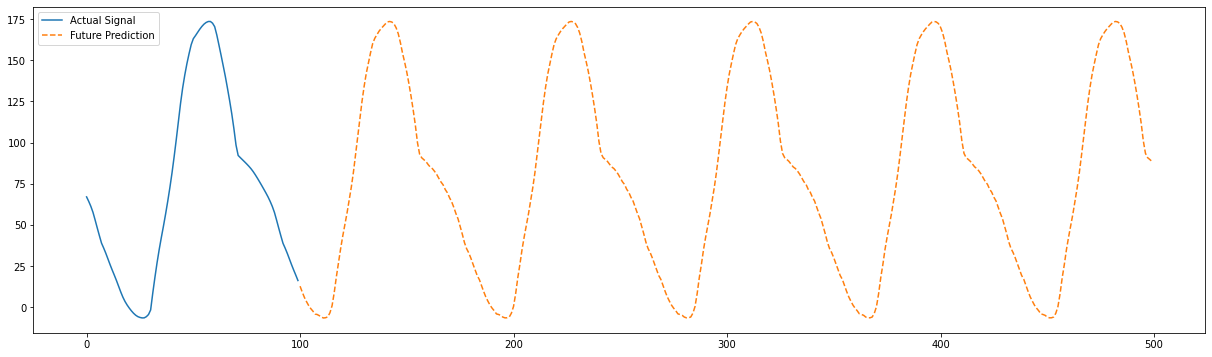

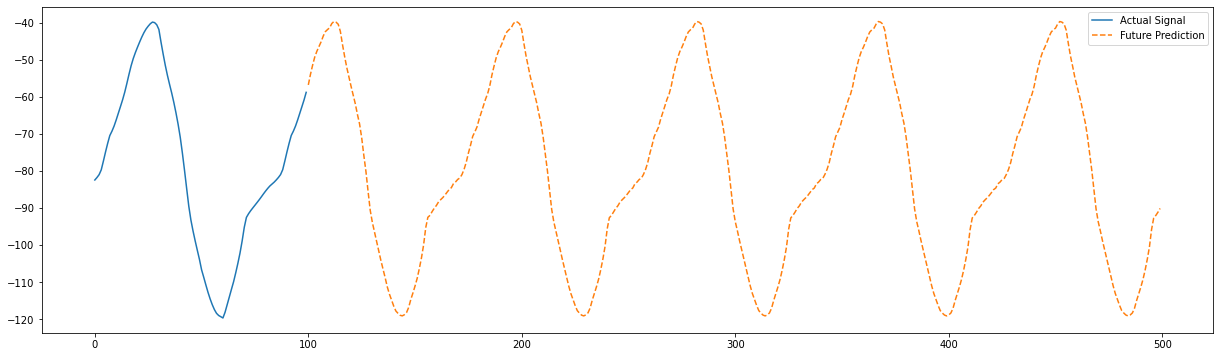

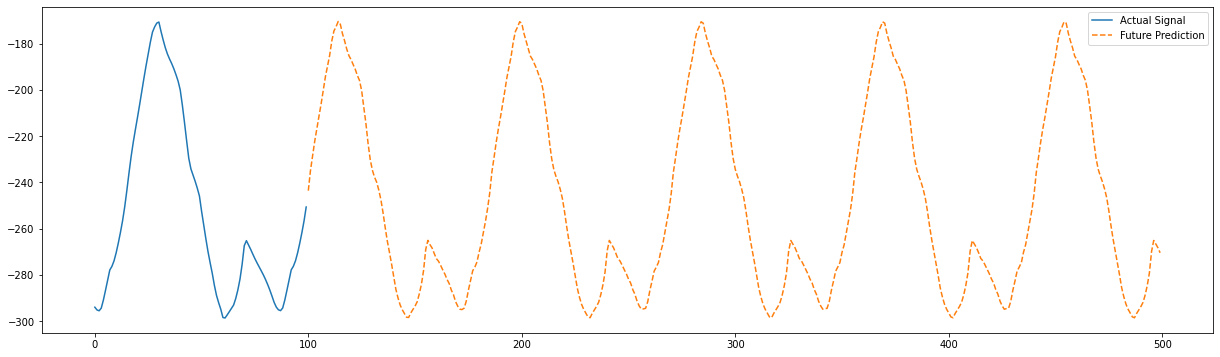

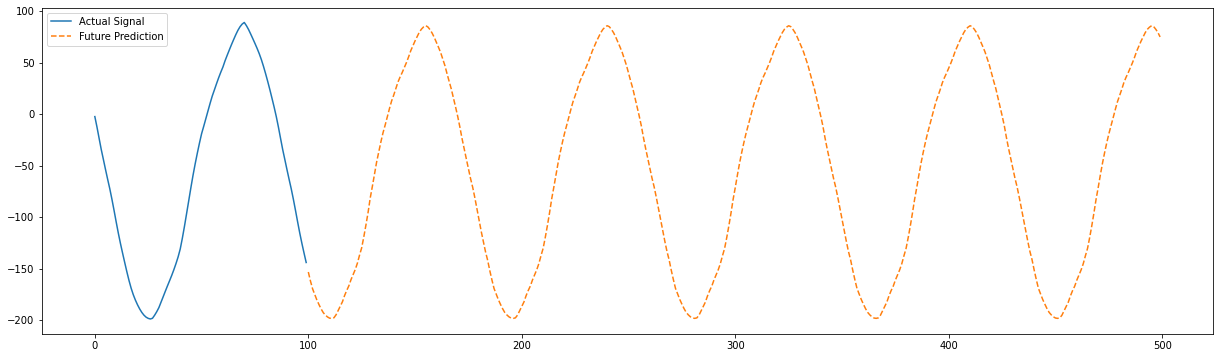

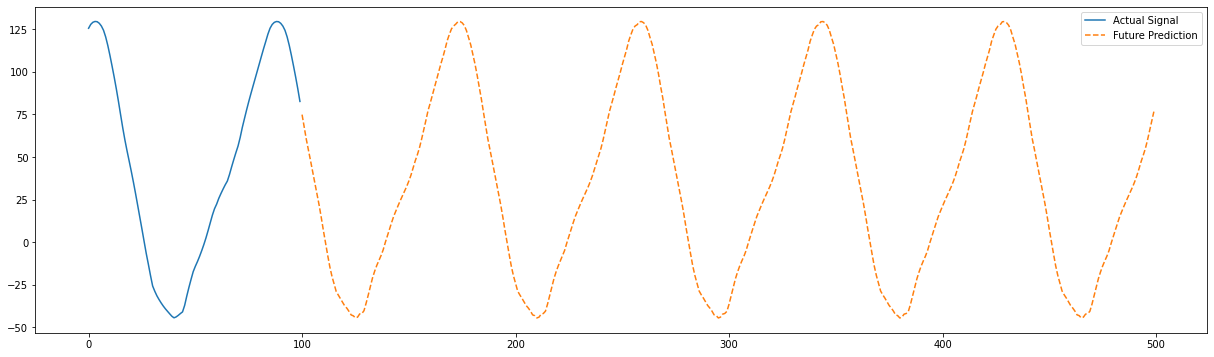

In [6]:
#Train all codes together---LSTM bounch Model
from dmd_machine.LSTM_bunch import *

lstm=LSTM_bunch()
units_LSTM=100 #The number of neurons of LSTM layer
# Create the LSTM-bunch model
timesteps = 1
latent_dim=encoding_dim
lstm_model = lstm.build_lstm_model_bunch(timesteps, latent_dim,units_LSTM)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
#lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0), loss='mse')

# Print LSTM model summary
lstm_model.summary()

#Input data of the LSTM-bunch model
encoded_data=y
print(encoded_data.shape)

# Reshape input for LSTM training
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, encoding_dim))
lstm_inputs=lstm.lstm_inputs(encoded_data)
print("lstm_inputs shape:",lstm_inputs.shape)
lstm_targets=lstm.lstm_targets(encoded_data)
print("lstm_targets shape:",lstm_inputs.shape)


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=10,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)
# Train the LSTM model
start_time = timeit.default_timer()
lstm_model.fit(lstm_inputs, lstm_targets, epochs=500, batch_size=32,validation_split=0.10,callbacks=[reduce_lr])
print("time spend for training:",timeit.default_timer() - start_time)

lstm_model.save('./Temp_data_Case1/model_bunch_'+str(encoding_dim)+'.h5')

lstm_model = load_model('./Temp_data_Case1/model_bunch_'+str(encoding_dim)+'.h5')

## Reshape for LSTM input
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, latent_dim))

# Predict future states using the LSTM model

predicted_latent = lstm_model.predict(encoded_data[:-1])
print(predicted_latent.shape)

# Decode the predictions to get the original space
decoded_predictions = ae.decoder.predict(np.reshape(predicted_latent, (predicted_latent.shape[0], latent_dim)))
print(decoded_predictions.shape)

# Number of future steps to predict
future_steps = 400
# Perform extrapolation
start_time = timeit.default_timer()
future_latent_predictions = lstm.extrapolate_lstm(lstm_model, encoded_data[-1].reshape(1,1,latent_dim),future_steps)
print(encoded_data[-1].shape)
future_latent_predictions=np.array(future_latent_predictions)
print("time spend for prediction:",timeit.default_timer() - start_time)

pickle.dump(future_latent_predictions, open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "wb"))
print(future_latent_predictions.shape)

# Decode the future latent predictions to the original space
decoded_future_predictions = [ae.decoder.predict(latent.reshape(1, -1)) for latent in future_latent_predictions]
print(np.array(decoded_future_predictions).shape)

# Combine the original and future predictions for the complete sequence
combined_predictions = np.concatenate([decoded_predictions, np.array(decoded_future_predictions).squeeze()])
print(np.array(decoded_future_predictions).squeeze().shape)
x_lstm=np.array(decoded_future_predictions).squeeze()
pickle.dump(x_lstm, open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", "wb"))

print(encoded_data.shape)
encoded_data_2=np.transpose(encoded_data.squeeze())
print(encoded_data_2.shape)

future_latent_predictions_2=np.transpose(future_latent_predictions)
print(future_latent_predictions_2.shape)


for idx in range(5):#Display curves of the first 5 signals #for idx in range(encoded_data_2.shape[0])
    plt.figure(figsize=(21, 6))
    plt.plot(encoded_data_2[idx, -100:], label='Actual Signal')#Presenting the last 100 values of each code
    plt.plot(np.arange(100, 100+ future_steps), future_latent_predictions_2[idx], label='Future Prediction', linestyle='dashed')
    plt.legend()
    plt.show()

(4601, 5)
(5, 4601)
training_data shape: (4601, 1)
(4511, 90, 1)
(4511, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 90, 100)           40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
the 0 signal
Epoch 1/500
127/127 [==============================] - 9s 60ms/step - loss: 0.0130 - val_loss: 0.0019
Epoch 2/500
127/127 [==============================] - 7s 56ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/500
127/127 [==============================] - 7s 57ms/step - loss: 9.9204e-04

127/127 [==============================] - 6s 48ms/step - loss: 8.2279e-06 - val_loss: 7.5802e-06
Epoch 137/500
127/127 [==============================] - 7s 53ms/step - loss: 8.0932e-06 - val_loss: 7.2849e-06
Epoch 138/500
127/127 [==============================] - 6s 48ms/step - loss: 8.1080e-06 - val_loss: 7.2355e-06
Epoch 139/500
127/127 [==============================] - 6s 49ms/step - loss: 8.0751e-06 - val_loss: 7.0139e-06
Epoch 140/500
127/127 [==============================] - 6s 49ms/step - loss: 8.0759e-06 - val_loss: 6.8585e-06
Epoch 141/500
127/127 [==============================] - 6s 51ms/step - loss: 8.1495e-06 - val_loss: 6.7476e-06
Epoch 142/500
127/127 [==============================] - 6s 47ms/step - loss: 7.8790e-06 - val_loss: 7.1498e-06
Epoch 143/500
127/127 [==============================] - 6s 47ms/step - loss: 7.9498e-06 - val_loss: 6.8467e-06
Epoch 144/500
127/127 [==============================] - 7s 52ms/step - loss: 7.9846e-06 - val_loss: 8.2472e-06
Epoch 

127/127 [==============================] - 7s 52ms/step - loss: 6.1304e-06 - val_loss: 5.2232e-06
Epoch 280/500
127/127 [==============================] - 6s 49ms/step - loss: 6.1172e-06 - val_loss: 5.1871e-06
Epoch 281/500
127/127 [==============================] - 6s 50ms/step - loss: 6.1256e-06 - val_loss: 5.1582e-06
Epoch 282/500
127/127 [==============================] - 6s 50ms/step - loss: 6.1363e-06 - val_loss: 5.1485e-06
Epoch 283/500
127/127 [==============================] - 6s 49ms/step - loss: 6.1295e-06 - val_loss: 5.1589e-06
Epoch 284/500
127/127 [==============================] - 6s 49ms/step - loss: 6.1185e-06 - val_loss: 5.1557e-06
Epoch 285/500
127/127 [==============================] - 7s 52ms/step - loss: 6.1259e-06 - val_loss: 5.1731e-06
Epoch 286/500
127/127 [==============================] - 6s 50ms/step - loss: 6.1213e-06 - val_loss: 5.2728e-06
Epoch 287/500
127/127 [==============================] - 6s 48ms/step - loss: 6.1296e-06 - val_loss: 5.1807e-06
Epoch 

127/127 [==============================] - 6s 49ms/step - loss: 5.9017e-06 - val_loss: 4.9309e-06
Epoch 424/500
127/127 [==============================] - 6s 49ms/step - loss: 5.9036e-06 - val_loss: 4.9421e-06
Epoch 425/500
127/127 [==============================] - 6s 50ms/step - loss: 5.9048e-06 - val_loss: 4.9342e-06
Epoch 426/500
127/127 [==============================] - 7s 51ms/step - loss: 5.8920e-06 - val_loss: 4.9416e-06
Epoch 427/500
127/127 [==============================] - 7s 52ms/step - loss: 5.9002e-06 - val_loss: 4.9254e-06
Epoch 428/500
127/127 [==============================] - 6s 50ms/step - loss: 5.9116e-06 - val_loss: 4.9256e-06
Epoch 429/500
127/127 [==============================] - 6s 50ms/step - loss: 5.8887e-06 - val_loss: 4.9370e-06
Epoch 430/500
127/127 [==============================] - 6s 48ms/step - loss: 5.8889e-06 - val_loss: 4.9442e-06
Epoch 431/500
127/127 [==============================] - 6s 48ms/step - loss: 5.8997e-06 - val_loss: 4.9440e-06
Epoch 

Epoch 495/500
127/127 [==============================] - 7s 56ms/step - loss: 5.8641e-06 - val_loss: 4.9084e-06
Epoch 496/500
127/127 [==============================] - 7s 53ms/step - loss: 5.8659e-06 - val_loss: 4.9114e-06
Epoch 497/500
127/127 [==============================] - 7s 55ms/step - loss: 5.8643e-06 - val_loss: 4.9070e-06
Epoch 498/500
127/127 [==============================] - 7s 53ms/step - loss: 5.8656e-06 - val_loss: 4.9079e-06
Epoch 499/500
127/127 [==============================] - 7s 53ms/step - loss: 5.8641e-06 - val_loss: 4.9095e-06
Epoch 500/500
127/127 [==============================] - 7s 54ms/step - loss: 5.8641e-06 - val_loss: 4.9097e-06
time spend for training: 3319.079226656999
time spend for prediction: 7.973924347999855
training_data shape: (4601, 1)
(4511, 90, 1)
(4511, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (N

127/127 [==============================] - 6s 49ms/step - loss: 4.6801e-06 - val_loss: 3.5113e-06
Epoch 133/500
127/127 [==============================] - 7s 53ms/step - loss: 4.5303e-06 - val_loss: 4.9045e-06
Epoch 134/500
127/127 [==============================] - 7s 54ms/step - loss: 4.1976e-06 - val_loss: 3.7676e-06
Epoch 135/500
127/127 [==============================] - 7s 51ms/step - loss: 3.8635e-06 - val_loss: 3.0622e-06
Epoch 136/500
127/127 [==============================] - 7s 53ms/step - loss: 4.3980e-06 - val_loss: 4.6139e-06
Epoch 137/500
127/127 [==============================] - 7s 52ms/step - loss: 4.2183e-06 - val_loss: 3.4828e-06
Epoch 138/500
127/127 [==============================] - 7s 53ms/step - loss: 4.1273e-06 - val_loss: 3.6346e-06
Epoch 139/500
127/127 [==============================] - 6s 50ms/step - loss: 4.4729e-06 - val_loss: 5.7578e-06
Epoch 140/500
127/127 [==============================] - 7s 52ms/step - loss: 4.5758e-06 - val_loss: 3.6132e-06
Epoch 

Epoch 204/500
127/127 [==============================] - 7s 54ms/step - loss: 2.9016e-06 - val_loss: 2.7215e-06
Epoch 205/500
127/127 [==============================] - 7s 52ms/step - loss: 2.7337e-06 - val_loss: 2.5723e-06
Epoch 206/500
127/127 [==============================] - 7s 55ms/step - loss: 2.7179e-06 - val_loss: 2.2387e-06
Epoch 207/500
127/127 [==============================] - 7s 58ms/step - loss: 2.7512e-06 - val_loss: 2.5535e-06
Epoch 208/500
127/127 [==============================] - 8s 60ms/step - loss: 2.7008e-06 - val_loss: 2.3939e-06
Epoch 209/500
127/127 [==============================] - 7s 58ms/step - loss: 2.6737e-06 - val_loss: 2.2111e-06
Epoch 210/500
127/127 [==============================] - 8s 60ms/step - loss: 2.8632e-06 - val_loss: 2.6453e-06
Epoch 211/500
127/127 [==============================] - 7s 55ms/step - loss: 2.8026e-06 - val_loss: 2.9261e-06
Epoch 212/500
127/127 [==============================] - 7s 57ms/step - loss: 2.7914e-06 - val_loss: 2.3

127/127 [==============================] - 7s 55ms/step - loss: 2.3382e-06 - val_loss: 2.0623e-06

Epoch 00344: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 345/500
127/127 [==============================] - 7s 58ms/step - loss: 2.3336e-06 - val_loss: 2.0644e-06
Epoch 346/500
127/127 [==============================] - 7s 55ms/step - loss: 2.3330e-06 - val_loss: 2.0601e-06
Epoch 347/500
127/127 [==============================] - 7s 57ms/step - loss: 2.3326e-06 - val_loss: 2.0593e-06
Epoch 348/500
127/127 [==============================] - 7s 56ms/step - loss: 2.3322e-06 - val_loss: 2.0593e-06
Epoch 349/500
127/127 [==============================] - 7s 53ms/step - loss: 2.3331e-06 - val_loss: 2.0596e-06
Epoch 350/500
127/127 [==============================] - 7s 58ms/step - loss: 2.3323e-06 - val_loss: 2.0601e-06
Epoch 351/500
127/127 [==============================] - 7s 51ms/step - loss: 2.3321e-06 - val_loss: 2.0607e-06
Epoch 352/500
127/127 [=============

127/127 [==============================] - 7s 51ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 481/500
127/127 [==============================] - 6s 50ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 482/500
127/127 [==============================] - 7s 52ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 483/500
127/127 [==============================] - 7s 52ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 484/500
127/127 [==============================] - 7s 52ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06

Epoch 00484: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
Epoch 485/500
127/127 [==============================] - 6s 51ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 486/500
127/127 [==============================] - 7s 53ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 487/500
127/127 [==============================] - 6s 50ms/step - loss: 2.3297e-06 - val_loss: 2.0593e-06
Epoch 488/500
127/127 [=============

Epoch 115/500
127/127 [==============================] - 6s 49ms/step - loss: 4.4579e-06 - val_loss: 4.0185e-06
Epoch 116/500
127/127 [==============================] - 6s 48ms/step - loss: 4.5493e-06 - val_loss: 4.5393e-06
Epoch 117/500
127/127 [==============================] - 7s 51ms/step - loss: 4.7629e-06 - val_loss: 4.9375e-06
Epoch 118/500
127/127 [==============================] - 6s 49ms/step - loss: 4.6659e-06 - val_loss: 4.2602e-06
Epoch 119/500
127/127 [==============================] - 6s 50ms/step - loss: 4.6460e-06 - val_loss: 4.4071e-06
Epoch 120/500
127/127 [==============================] - 7s 51ms/step - loss: 4.5066e-06 - val_loss: 4.5745e-06
Epoch 121/500
127/127 [==============================] - 6s 50ms/step - loss: 4.4100e-06 - val_loss: 4.3894e-06
Epoch 122/500
127/127 [==============================] - 6s 51ms/step - loss: 4.5539e-06 - val_loss: 4.3921e-06
Epoch 123/500
127/127 [==============================] - 7s 52ms/step - loss: 4.9054e-06 - val_loss: 5.3

Epoch 186/500
127/127 [==============================] - 6s 49ms/step - loss: 3.8728e-06 - val_loss: 3.6883e-06
Epoch 187/500
127/127 [==============================] - 6s 50ms/step - loss: 3.9230e-06 - val_loss: 3.6958e-06
Epoch 188/500
127/127 [==============================] - 6s 49ms/step - loss: 3.9465e-06 - val_loss: 3.8625e-06

Epoch 00188: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 189/500
127/127 [==============================] - 6s 51ms/step - loss: 3.8663e-06 - val_loss: 3.6492e-06
Epoch 190/500
127/127 [==============================] - 7s 52ms/step - loss: 3.8660e-06 - val_loss: 3.6996e-06
Epoch 191/500
127/127 [==============================] - 6s 49ms/step - loss: 3.8673e-06 - val_loss: 3.7142e-06
Epoch 192/500
127/127 [==============================] - 6s 49ms/step - loss: 3.8646e-06 - val_loss: 3.6949e-06
Epoch 193/500
127/127 [==============================] - 7s 53ms/step - loss: 3.8462e-06 - val_loss: 3.6546e-06
Epoch 194/500
127/127 [

127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 324/500
127/127 [==============================] - 6s 49ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 325/500
127/127 [==============================] - 6s 48ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 326/500
127/127 [==============================] - 7s 54ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 327/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 328/500
127/127 [==============================] - 7s 51ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 329/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 330/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 331/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 

Epoch 392/500
127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06

Epoch 00392: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
Epoch 393/500
127/127 [==============================] - 6s 51ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 394/500
127/127 [==============================] - 6s 49ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 395/500
127/127 [==============================] - 7s 51ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 396/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 397/500
127/127 [==============================] - 7s 51ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 398/500
127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 399/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 400/500
127/127 

127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 461/500
127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 462/500
127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06

Epoch 00462: ReduceLROnPlateau reducing learning rate to 1.164153273563659e-13.
Epoch 463/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 464/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 465/500
127/127 [==============================] - 7s 52ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 466/500
127/127 [==============================] - 6s 51ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 467/500
127/127 [==============================] - 6s 50ms/step - loss: 3.7822e-06 - val_loss: 3.6072e-06
Epoch 468/500
127/127 [==============

127/127 [==============================] - 6s 50ms/step - loss: 4.7177e-06 - val_loss: 7.2181e-06
Epoch 95/500
127/127 [==============================] - 7s 52ms/step - loss: 6.5599e-06 - val_loss: 7.5762e-06
Epoch 96/500
127/127 [==============================] - 7s 52ms/step - loss: 7.5993e-06 - val_loss: 4.7728e-06
Epoch 97/500
127/127 [==============================] - 7s 52ms/step - loss: 6.3195e-06 - val_loss: 7.4040e-06
Epoch 98/500
127/127 [==============================] - 6s 51ms/step - loss: 5.5172e-06 - val_loss: 2.3308e-06
Epoch 99/500
127/127 [==============================] - 6s 50ms/step - loss: 5.5806e-06 - val_loss: 6.1008e-06
Epoch 100/500
127/127 [==============================] - 6s 50ms/step - loss: 4.7520e-06 - val_loss: 2.6039e-06
Epoch 101/500
127/127 [==============================] - 6s 50ms/step - loss: 6.0710e-06 - val_loss: 5.0951e-06
Epoch 102/500
127/127 [==============================] - 6s 50ms/step - loss: 5.4568e-06 - val_loss: 2.7247e-06
Epoch 103/5

Epoch 166/500
127/127 [==============================] - 7s 55ms/step - loss: 2.4003e-06 - val_loss: 1.5982e-06
Epoch 167/500
127/127 [==============================] - 7s 53ms/step - loss: 2.3224e-06 - val_loss: 1.7590e-06
Epoch 168/500
127/127 [==============================] - 7s 52ms/step - loss: 2.5586e-06 - val_loss: 1.8548e-06
Epoch 169/500
127/127 [==============================] - 7s 52ms/step - loss: 2.2279e-06 - val_loss: 1.3347e-06
Epoch 170/500
127/127 [==============================] - 7s 52ms/step - loss: 2.3936e-06 - val_loss: 2.3836e-06
Epoch 171/500
127/127 [==============================] - 7s 51ms/step - loss: 2.2402e-06 - val_loss: 1.8187e-06

Epoch 00171: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 172/500
127/127 [==============================] - 7s 54ms/step - loss: 2.0475e-06 - val_loss: 1.2875e-06
Epoch 173/500
127/127 [==============================] - 7s 52ms/step - loss: 2.0418e-06 - val_loss: 1.2027e-06
Epoch 174/500
127/127 [

127/127 [==============================] - 7s 52ms/step - loss: 1.7363e-06 - val_loss: 1.1017e-06
Epoch 306/500
127/127 [==============================] - 6s 51ms/step - loss: 1.7365e-06 - val_loss: 1.1032e-06
Epoch 307/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7361e-06 - val_loss: 1.1021e-06
Epoch 308/500
127/127 [==============================] - 7s 53ms/step - loss: 1.7365e-06 - val_loss: 1.1026e-06
Epoch 309/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7363e-06 - val_loss: 1.1011e-06
Epoch 310/500
127/127 [==============================] - 7s 52ms/step - loss: 1.7359e-06 - val_loss: 1.1045e-06
Epoch 311/500
127/127 [==============================] - 7s 53ms/step - loss: 1.7362e-06 - val_loss: 1.1037e-06
Epoch 312/500
127/127 [==============================] - 6s 50ms/step - loss: 1.7349e-06 - val_loss: 1.0993e-06
Epoch 313/500
127/127 [==============================] - 7s 55ms/step - loss: 1.7361e-06 - val_loss: 1.1005e-06
Epoch 

Epoch 374/500
127/127 [==============================] - 7s 52ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 375/500
127/127 [==============================] - 7s 54ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 376/500
127/127 [==============================] - 6s 50ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 377/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 378/500
127/127 [==============================] - 6s 50ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 379/500
127/127 [==============================] - 7s 53ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 380/500
127/127 [==============================] - 6s 51ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 381/500
127/127 [==============================] - 7s 54ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 382/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7340e-06 - val_loss: 1.1


Epoch 00442: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
Epoch 443/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 444/500
127/127 [==============================] - 7s 55ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 445/500
127/127 [==============================] - 7s 51ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 446/500
127/127 [==============================] - 7s 52ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 447/500
127/127 [==============================] - 7s 52ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 448/500
127/127 [==============================] - 7s 54ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 449/500
127/127 [==============================] - 7s 56ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 450/500
127/127 [==============================] - 7s 54ms/step - loss: 1.7340e-06 - val_loss: 1.1010e-06
Epoch 451/500
127/127 

127/127 [==============================] - 6s 50ms/step - loss: 1.4460e-05 - val_loss: 9.0248e-06
Epoch 76/500
127/127 [==============================] - 7s 53ms/step - loss: 1.4541e-05 - val_loss: 9.3467e-06
Epoch 77/500
127/127 [==============================] - 6s 51ms/step - loss: 1.3884e-05 - val_loss: 7.4807e-06
Epoch 78/500
127/127 [==============================] - 7s 52ms/step - loss: 1.4125e-05 - val_loss: 7.6343e-06
Epoch 79/500
127/127 [==============================] - 7s 53ms/step - loss: 1.4574e-05 - val_loss: 1.1097e-05
Epoch 80/500
127/127 [==============================] - 7s 51ms/step - loss: 1.4728e-05 - val_loss: 1.1093e-05
Epoch 81/500
127/127 [==============================] - 49874s 396s/step - loss: 1.4684e-05 - val_loss: 1.3139e-05
Epoch 82/500
127/127 [==============================] - 7s 54ms/step - loss: 1.5257e-05 - val_loss: 7.6113e-06
Epoch 83/500
127/127 [==============================] - 7s 52ms/step - loss: 1.4308e-05 - val_loss: 8.7218e-06
Epoch 84/5


Epoch 00216: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 217/500
127/127 [==============================] - 7s 53ms/step - loss: 8.0339e-06 - val_loss: 5.4643e-06
Epoch 218/500
127/127 [==============================] - 7s 52ms/step - loss: 8.0333e-06 - val_loss: 5.4120e-06
Epoch 219/500
127/127 [==============================] - 6s 48ms/step - loss: 8.0632e-06 - val_loss: 5.4494e-06
Epoch 220/500
127/127 [==============================] - 7s 55ms/step - loss: 8.0506e-06 - val_loss: 5.4076e-06
Epoch 221/500
127/127 [==============================] - 7s 51ms/step - loss: 8.0475e-06 - val_loss: 5.4751e-06
Epoch 222/500
127/127 [==============================] - 7s 54ms/step - loss: 8.0410e-06 - val_loss: 5.4445e-06
Epoch 223/500
127/127 [==============================] - 7s 56ms/step - loss: 8.0626e-06 - val_loss: 5.4094e-06
Epoch 224/500
127/127 [==============================] - 7s 54ms/step - loss: 8.0440e-06 - val_loss: 5.3932e-06
Epoch 225/500
127/127 

127/127 [==============================] - 7s 56ms/step - loss: 7.8599e-06 - val_loss: 5.2943e-06
Epoch 361/500
127/127 [==============================] - 7s 58ms/step - loss: 7.8570e-06 - val_loss: 5.2918e-06
Epoch 362/500
127/127 [==============================] - 7s 55ms/step - loss: 7.8590e-06 - val_loss: 5.3026e-06
Epoch 363/500
127/127 [==============================] - 7s 56ms/step - loss: 7.8592e-06 - val_loss: 5.2975e-06
Epoch 364/500
127/127 [==============================] - 7s 55ms/step - loss: 7.8632e-06 - val_loss: 5.2994e-06
Epoch 365/500
127/127 [==============================] - 7s 57ms/step - loss: 7.8614e-06 - val_loss: 5.2924e-06
Epoch 366/500
127/127 [==============================] - 7s 55ms/step - loss: 7.8554e-06 - val_loss: 5.2960e-06
Epoch 367/500
127/127 [==============================] - 7s 52ms/step - loss: 7.8627e-06 - val_loss: 5.2981e-06
Epoch 368/500
127/127 [==============================] - 7s 51ms/step - loss: 7.8595e-06 - val_loss: 5.2954e-06
Epoch 

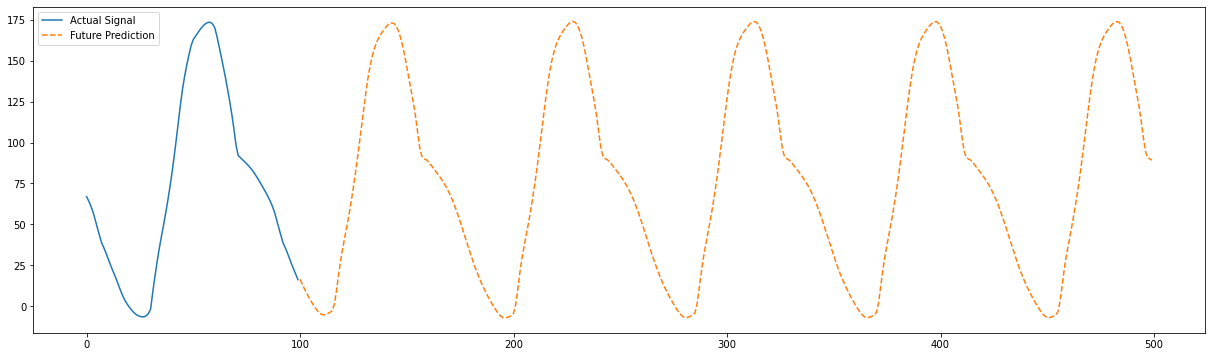

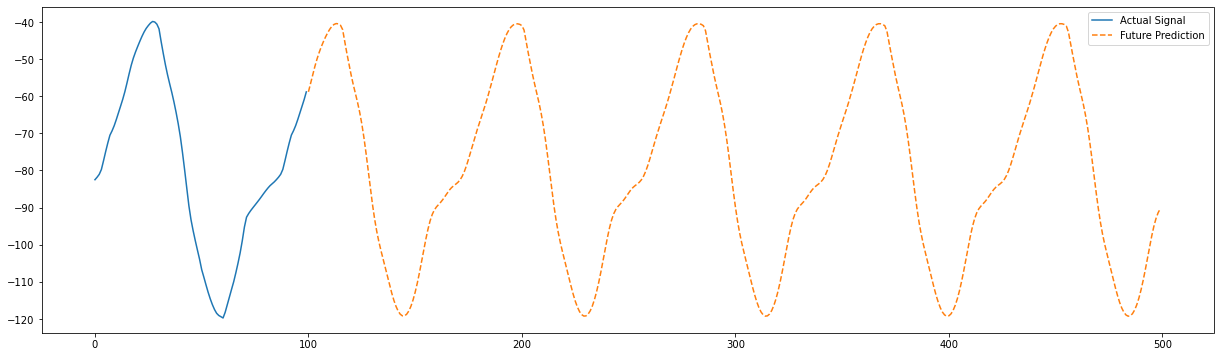

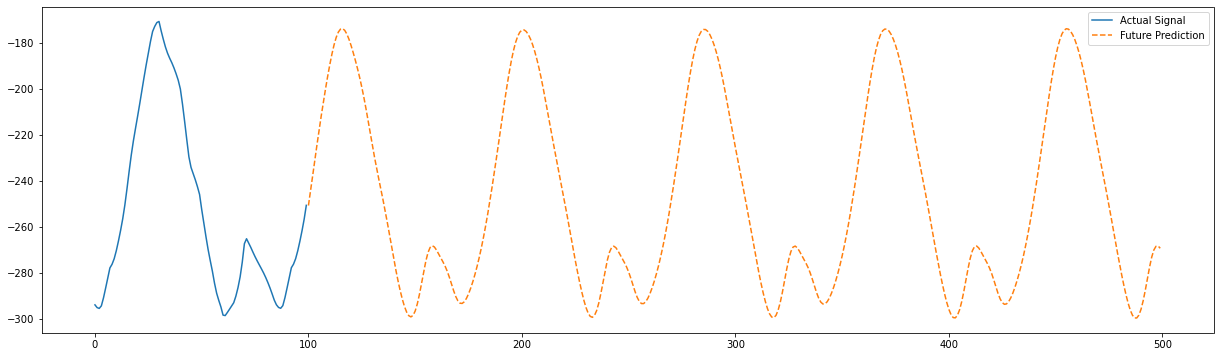

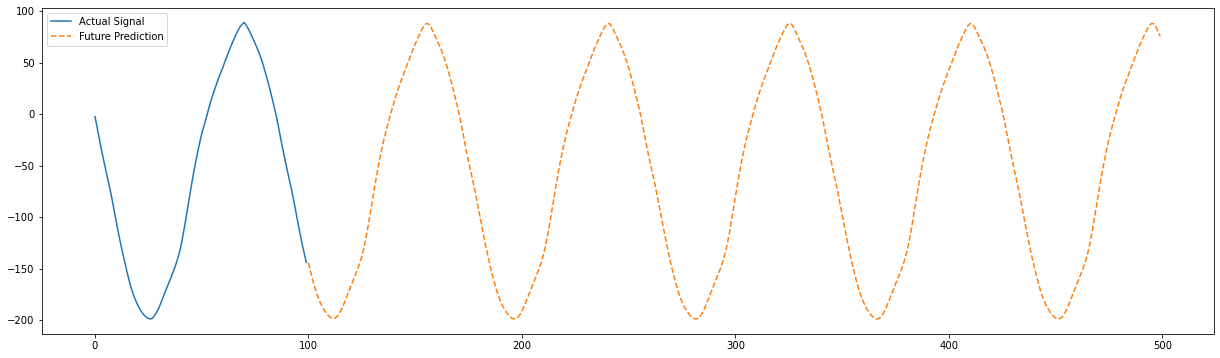

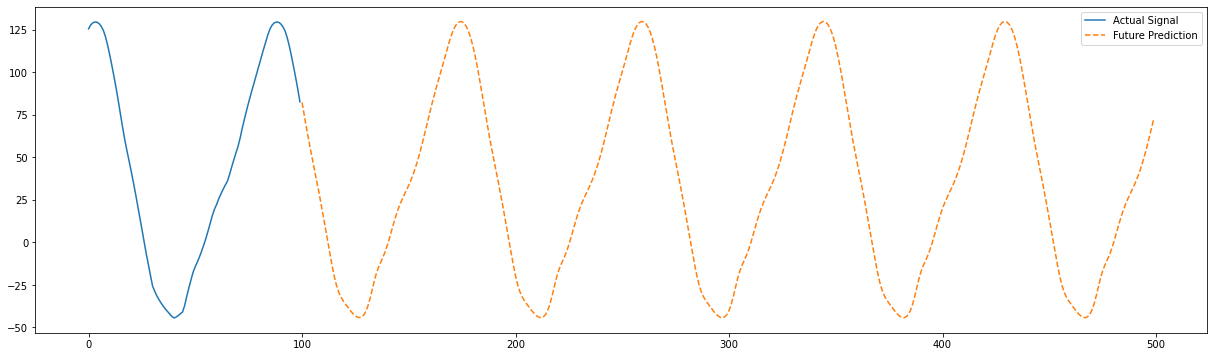

In [19]:
#Train each code using a single LSTM model---LSTM-individual Model
from sklearn.preprocessing import MinMaxScaler
from dmd_machine.LSTM_individual import *

lstm_individual=LSTM_individual( )

units_LSTM=100
future_steps=400

print(y.shape)
# input data of LSTM-individual model
data=np.array(np.transpose(y))
print(data.shape)

# Define the sequence length for LSTM
seq_length_collection =[90]#[10,20,30,40,50,60,80,70,90,100]
future_steps = pred_time_steps  # Number of future steps to predict

for seq_length in seq_length_collection:
    # Placeholder for reconstructed signals
    reconstructed_signals = []
    future_predictions_lstm = []

    # Loop over each signal
    for idx in range(data.shape[0]):
        start_time = timeit.default_timer()
        
        training_data = data[idx].reshape(data.shape[1],1)
        print('training_data shape:',training_data.shape)
    
        # Normalize the data
        scaler = MinMaxScaler()
        training_data_scaled = scaler.fit_transform(training_data)    
         
        X_train, y_train =lstm_individual.create_sequences(training_data_scaled, seq_length)
        print(X_train.shape)
        print(y_train.shape)

    
        # Build the LSTM model
        model = lstm_individual.build_lstm_model_individual(seq_length, X_train.shape[2],units_LSTM)
    
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        model.summary()

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')        
              
        
        print("the {0} signal".format(idx))
        # Callbacks
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.5,
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            min_delta=1e-10,
                                            cooldown=0,
                                            min_lr=0)
        # Train the LSTM model
        model.fit(X_train, y_train,  epochs=500, batch_size=32,validation_split=0.1,callbacks=[reduce_lr])
        print("time spend for training:",timeit.default_timer() - start_time)
      
        # Make predictions
        start_time = timeit.default_timer()
        last_sequence = X_train[-1]
        
        future_latent_predictions = lstm_individual.extrapolate_lstm(model, last_sequence, future_steps)
       
    
        # Rescale and sum future steps to reconstruct future snapshots
        future_signal = scaler.inverse_transform(future_latent_predictions)
        future_predictions_lstm.append(future_signal)
        print("time spend for prediction:",timeit.default_timer() - start_time)
    

    future_predictions_lstm = np.array(future_predictions_lstm)
    pickle.dump(future_predictions_lstm, open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "wb"))

    print(future_predictions_lstm.shape)

    # Plot the actual and predicted codes
    for idx in range(data.shape[0]):
        plt.figure(figsize=(21, 6))
        plt.plot(data[idx, -100:], label='Actual Signal')#Presenting the last 100 values of each code
        plt.plot(np.arange(100, 100+ future_steps), future_predictions_lstm[idx], label='Future Prediction', linestyle='dashed')
        plt.legend()
        plt.show()
        

(5, 400, 1)
(5, 400)
(5, 4601)
(100,)
(400, 1)
(5, 400)


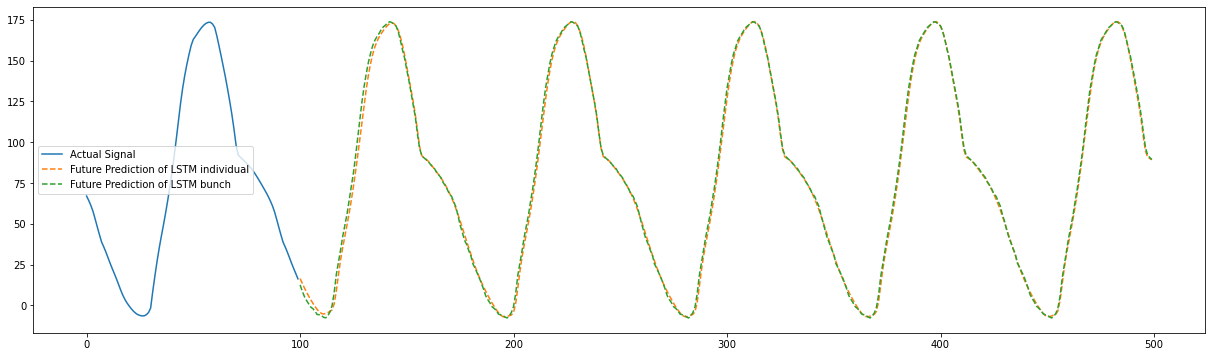

(100,)
(400, 1)
(5, 400)


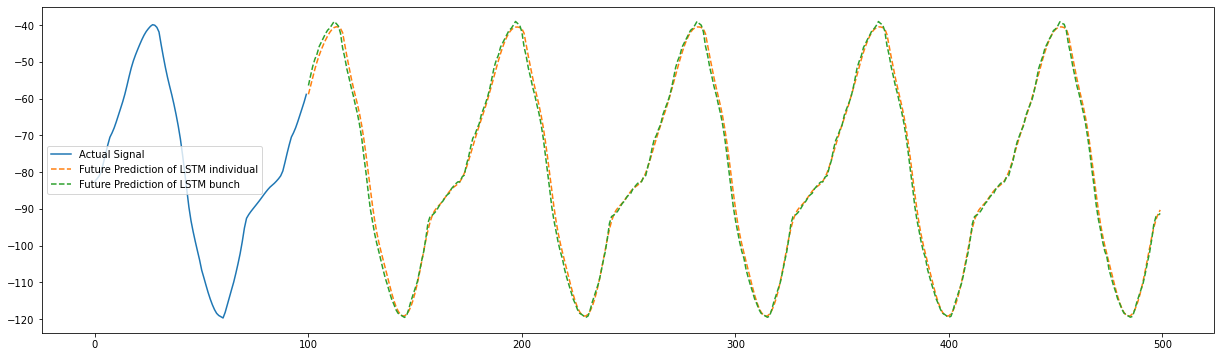

(100,)
(400, 1)
(5, 400)


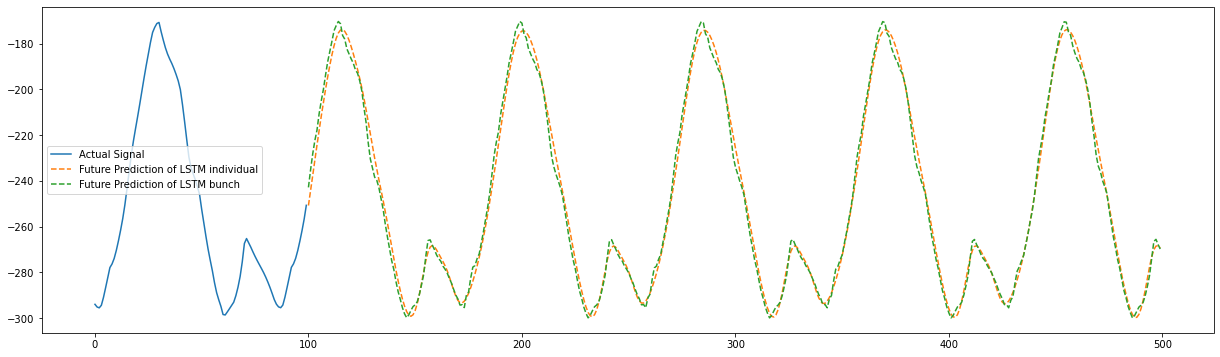

(100,)
(400, 1)
(5, 400)


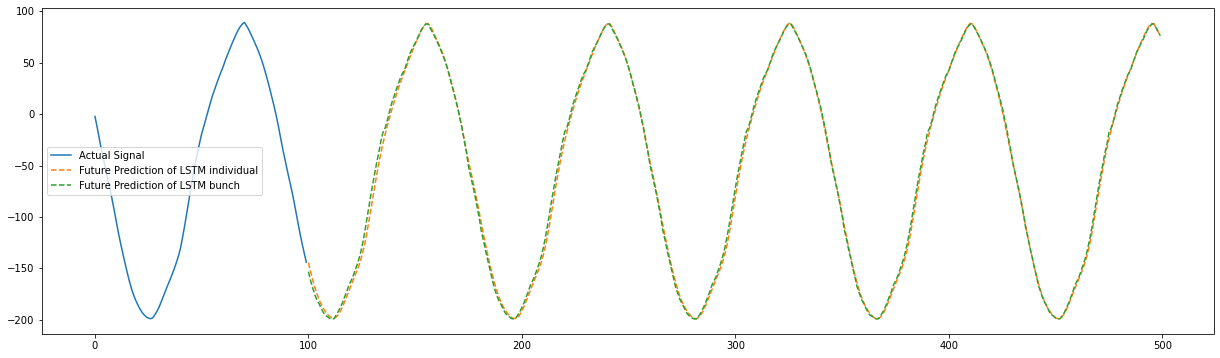

(100,)
(400, 1)
(5, 400)


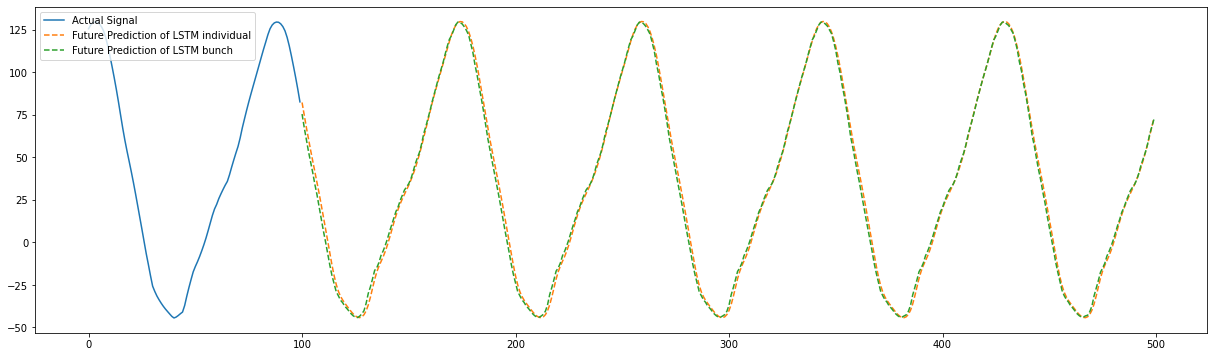

In [20]:
seq_length=90
future_predictions_lstm=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "rb"))
print(future_predictions_lstm.shape)
future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)

data=np.array(np.transpose(y))
print(data.shape)
# Plot the actual and predicted codes (both LSTM-individual and LSTM-bunch) for comparison
for idx in range(data.shape[0]):
    plt.figure(figsize=(21, 6))
    print(data[idx, -100:].shape)
    plt.plot(data[idx, -100:], label='Actual Signal')
    
    print(future_predictions_lstm[idx].shape)
    plt.plot(np.arange(100, 100 + future_steps), future_predictions_lstm[idx], label='Future Prediction of LSTM individual', linestyle='dashed')
    print(future_latent_predictions_lstm_bunch.shape)
    plt.plot(np.arange(100, 100 + future_steps), future_latent_predictions_lstm_bunch[idx], label='Future Prediction of LSTM bunch', linestyle='dashed')
    plt.legend()
    plt.show()

In [6]:
#Import DMD model
from dmd_machine.DMD import *
#The prediction result of SAE-DMD model in different code length
encoding_dim =5# [5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

y=ae.encoder(two_dimension_data_0)
future_steps=pred_time_steps

dmd=DMD()
# start timer.
start_time = timeit.default_timer()

print("y.shape",y.shape)
y_pred = dmd.get_predicted_y(tf.transpose(y),int(encoding_dim),future_steps)# rank equals 10 and estimate time step equals 10
print("y_pred_before_transpose",y_pred.shape)

print("time spend for prediction:",timeit.default_timer() - start_time)

# Convert lists to numpy arrays
y_original=tf.transpose(y)
print("Original code",y_original.shape)

y_pred = np.array(y_pred)
pickle.dump(y_pred, open("./Temp_data_Case1/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", "wb"))

print("DMD predict",y_pred.shape)

y.shape (4601, 5)
Singular value matrix's shape (5,)
Singular value array [19881.049    7259.2866   4234.0737    894.82104    77.0632 ]
(5, 5)
y_pred_before_transpose (5, 4601)
time spend for prediction: 0.012026900000002172
Original code (5, 4601)
DMD predict (5, 4601)


(5, 400, 1)
LSTM predict (5, 400)
LSTM predict&original (5, 4601)
(5, 400)
(5, 4601)
LSTM predict_bunch&original (5, 4601)


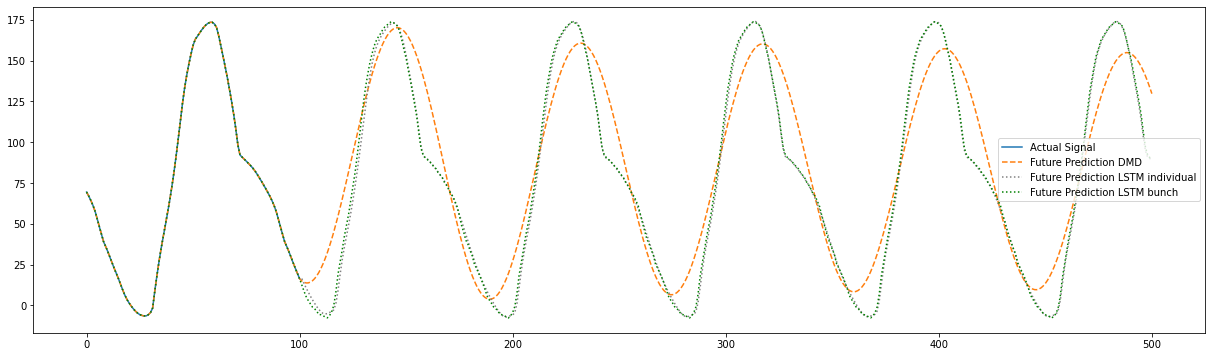

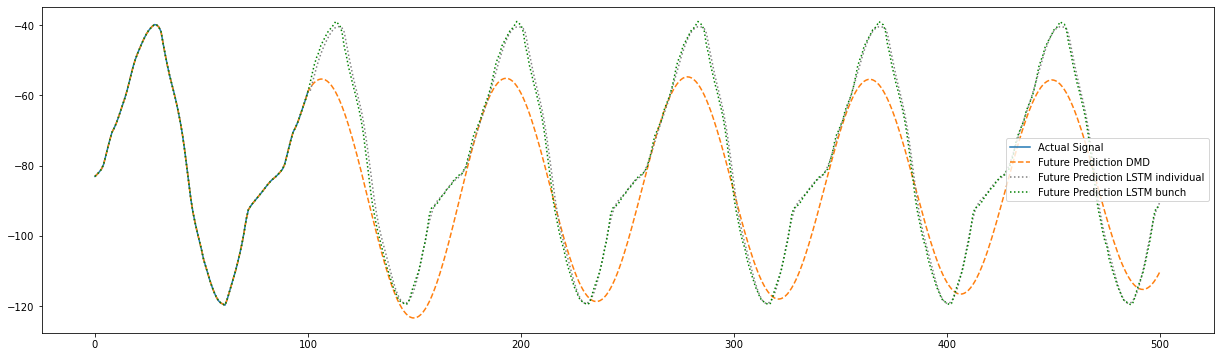

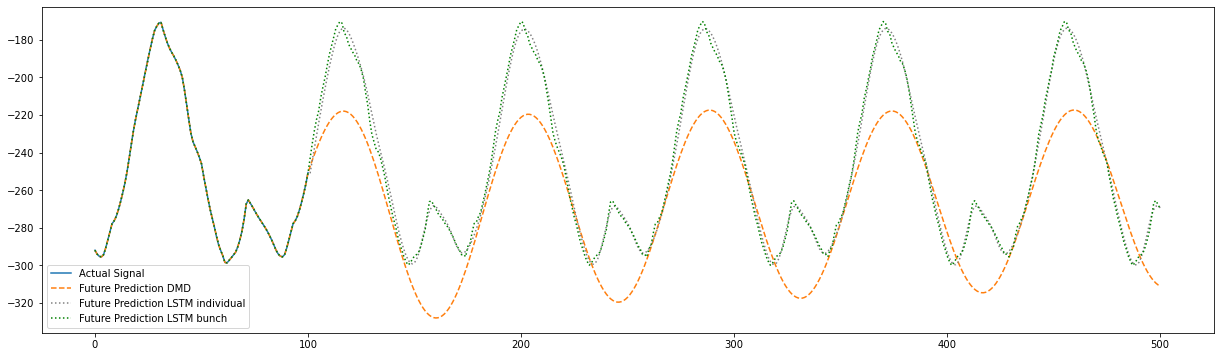

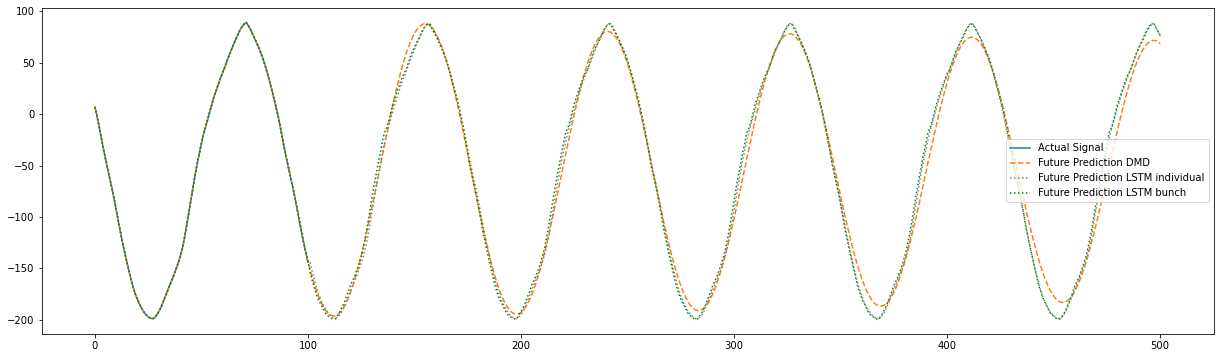

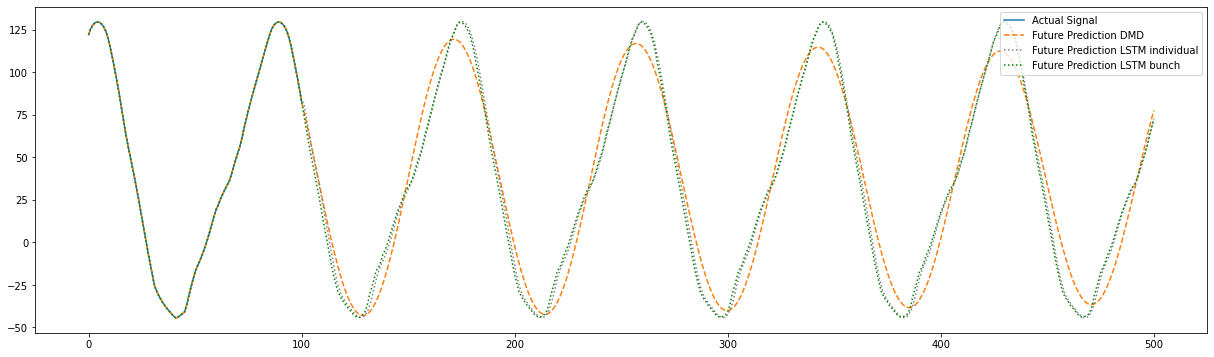

In [24]:
seq_length=90
future_predictions_lstm=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))
print(future_predictions_lstm.shape)
future_predictions_lstm_reshape=np.reshape(future_predictions_lstm,(encoding_dim,-1))
print("LSTM predict",future_predictions_lstm_reshape.shape)
future_predictions_lstm_combine=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_predictions_lstm_reshape))))
print("LSTM predict&original",future_predictions_lstm_combine.shape)

future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)
print(y_original.shape)
future_predictions_lstm_combine_bunch=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_latent_predictions_lstm_bunch))))
print("LSTM predict_bunch&original",future_predictions_lstm_combine_bunch.shape)

# Plot the actual and predicted codes (DMD, LSTM-individual and LSTM-bunch) for comparison
for idx in range(y_original.shape[0]):
    plt.figure(figsize=(21, 6))
    plt.plot(y_original[idx, -(101):], label='Actual Signal')
    plt.plot(y_pred[idx, -(101+future_steps):], label='Future Prediction DMD', linestyle='dashed')
    plt.plot(future_predictions_lstm_combine[idx, -(101+future_steps):], label='Future Prediction LSTM individual', color='grey',linestyle='dotted')
    plt.plot(future_predictions_lstm_combine_bunch[idx, -(101+future_steps):], label='Future Prediction LSTM bunch', color='green',linestyle='dotted')
    plt.legend()
    plt.show()

In [4]:
#Reconstruct the code back into the origin like array
def recontruction(ae,code):
    code_transp=np.transpose(code)
    x_ae=ae.decoder(code_transp)
    print(x_ae.shape)
    outputs=np.array(x_ae).reshape(code_transp.shape[0],training_data_whole.shape[1],2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs

#Inverse scale the reconstructed data into the origin like array
def scalar_inverse(reconstructed_data):
    outputs=np.array(reconstructed_data).reshape(reconstructed_data.shape[0],training_data_whole.shape[1],2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs 

#Calculat the magnitude of the velocity on x and y direction
def cal_Magnitude(data):
    three_dimension_data=np.array(data).transpose(1,2,0)

    two_dimension_data=np.zeros((three_dimension_data.shape[0], three_dimension_data.shape[2]), dtype=np.float32)
    #print(two_dimension_data.shape)
    for i in range(0, three_dimension_data.shape[0]):
        for j in range(0, three_dimension_data.shape[2]):
            magnitude=math.sqrt(pow(three_dimension_data[i,0,j],2)+pow(three_dimension_data[i,1,j],2))
            two_dimension_data[i][j]=magnitude
    two_dimension_data=two_dimension_data.reshape(two_dimension_data.shape[1],two_dimension_data.shape[0])
    return two_dimension_data

In [27]:
#Comparsion of reconstruction accuracy between SAE and POD in different code length
# start timer.
start_time = timeit.default_timer()

#Display the last 400 snapshots
ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[4201:4601]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./Temp_data_Case1/ori_data3.pkl", "wb"))

rom_data_0=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(5)+"_POD.pkl", "rb"))[4201:4601]
rom_data_03=cal_Magnitude(scalar_inverse(rom_data_0))
pickle.dump(rom_data_03, open("./Temp_data_Case1/rom_data_03.pkl", "wb"))

rom_data_1=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(10)+"_POD.pkl", "rb"))[4201:4601]
rom_data_13=cal_Magnitude(scalar_inverse(rom_data_1))
pickle.dump(rom_data_13, open("./Temp_data_Case1/rom_data_13.pkl", "wb"))

rom_data_2=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(45)+"_POD.pkl", "rb"))[4201:4601]
rom_data_23=cal_Magnitude(scalar_inverse(rom_data_2))
pickle.dump(rom_data_23, open("./Temp_data_Case1/rom_data_23.pkl", "wb"))

rom_data_3=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(5)+"_SAE.pkl", "rb"))[4201:4601]
rom_data_33=cal_Magnitude(scalar_inverse(rom_data_3))
pickle.dump(rom_data_33, open("./Temp_data_Case1/rom_data_33.pkl", "wb"))

rom_data_4=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(10)+"_SAE.pkl", "rb"))[4201:4601]
rom_data_43=cal_Magnitude(scalar_inverse(rom_data_4))
pickle.dump(rom_data_43, open("./Temp_data_Case1/rom_data_43.pkl", "wb"))

rom_data_5=joblib.load(open("./Temp_data_Case1/reconstructed_data_"+str(45)+"_SAE.pkl", "rb"))[4201:4601]
rom_data_53=cal_Magnitude(scalar_inverse(rom_data_5))
pickle.dump(rom_data_53, open("./Temp_data_Case1/rom_data_53.pkl", "wb"))

print("time spend for calculation:",timeit.default_timer() - start_time)

(400, 84180, 2)
time spend for calculation: 430.9587733329972


In [23]:
ori_data2=joblib.load(open('./Temp_data_Case1/ori_data3.pkl', 'rb'))

rom_data_02=joblib.load(open('./Temp_data_Case1/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case1/rom_data_13.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case1/rom_data_23.pkl', 'rb'))
rom_data_32=joblib.load(open('./Temp_data_Case1/rom_data_33.pkl', 'rb'))
rom_data_42=joblib.load(open('./Temp_data_Case1/rom_data_43.pkl', 'rb'))
rom_data_52=joblib.load(open('./Temp_data_Case1/rom_data_53.pkl', 'rb'))


In [5]:
from dmd_machine import Model_Processing_7inputs_2_SAE_POD as MP7

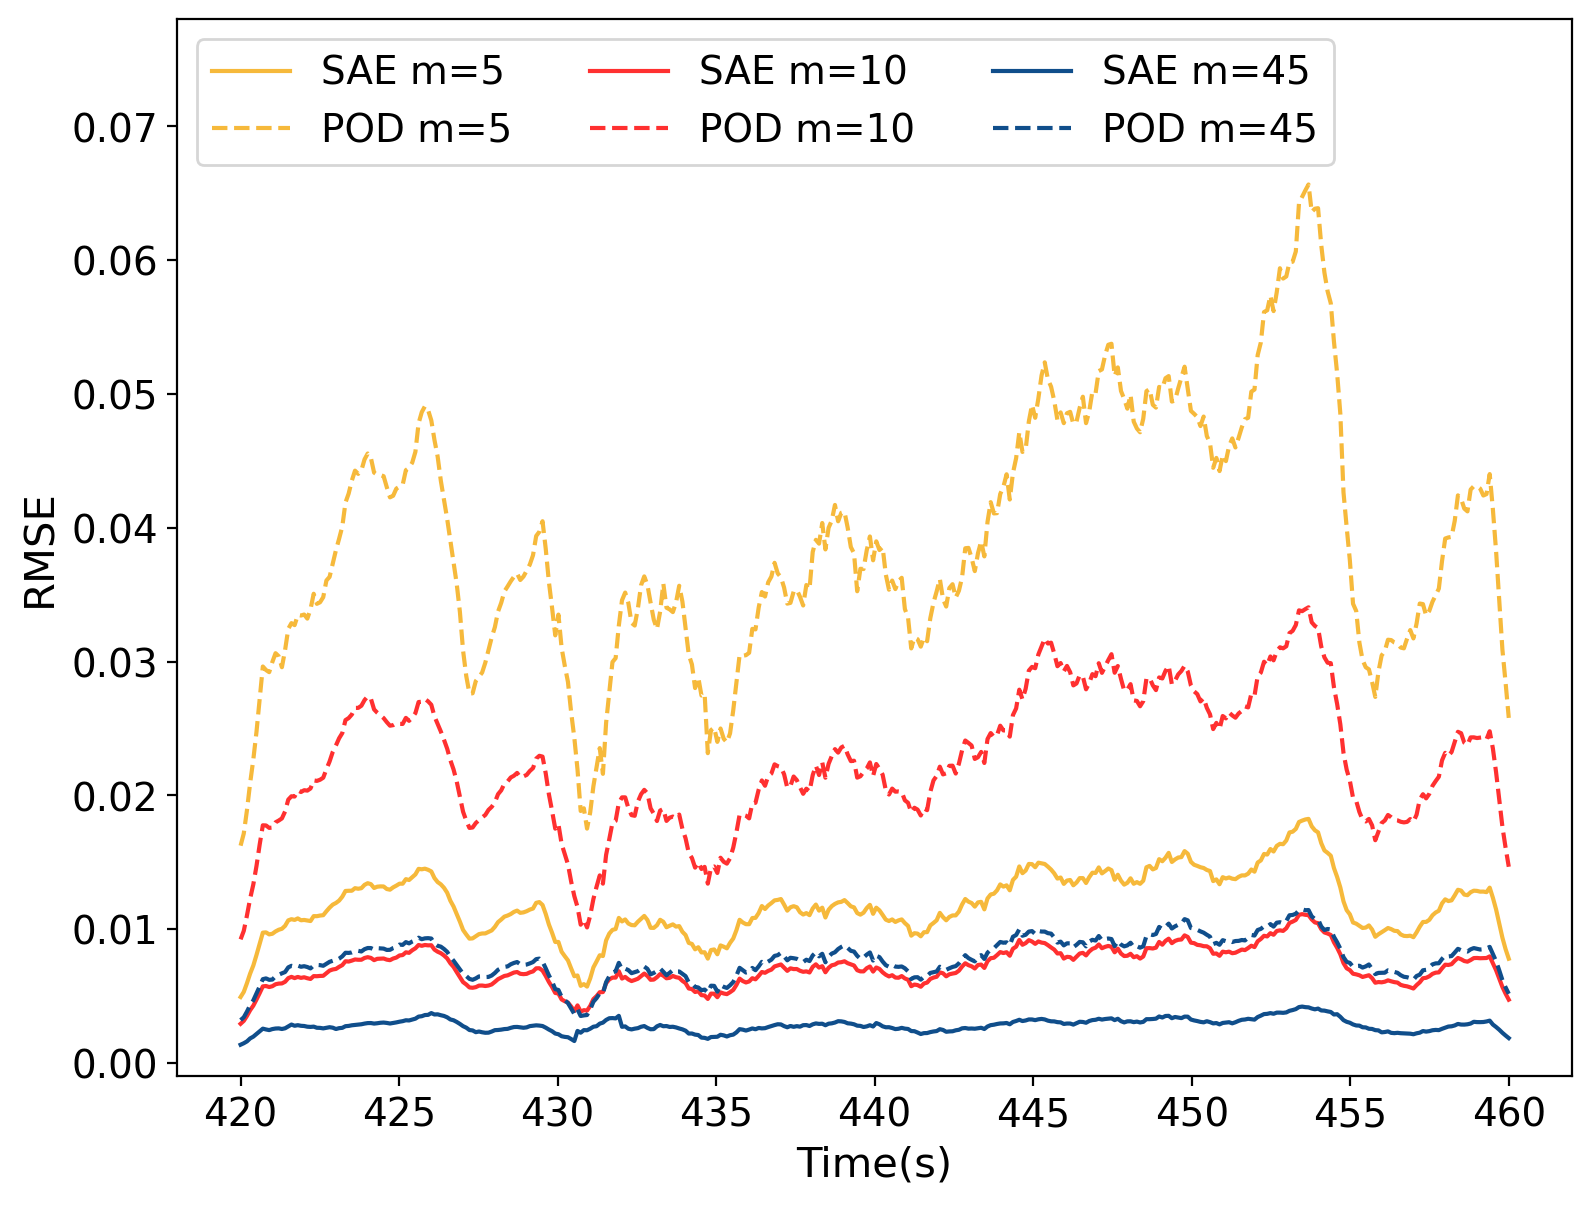

In [11]:
MP7.rmse_over_time(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,'Velocity',0.078,420)


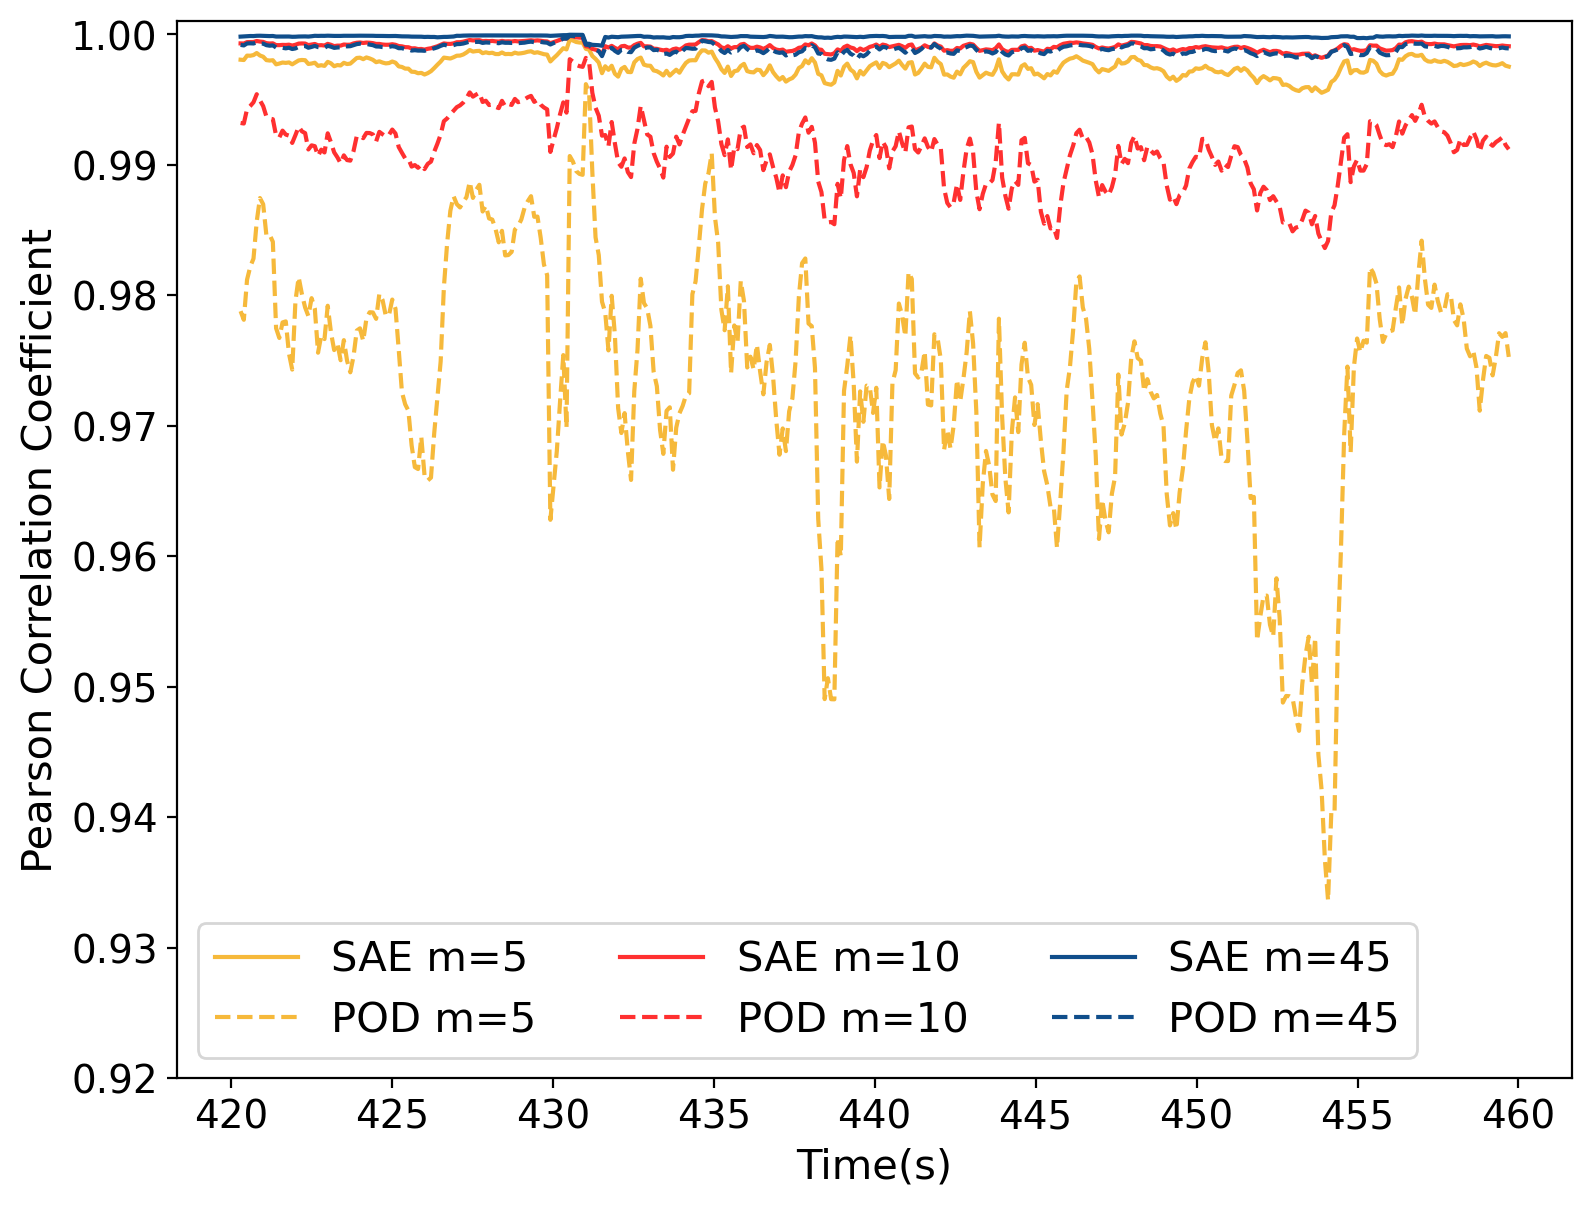

In [24]:
MP7.cc(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,0.92,'Velocity',420)

In [ ]:
#Parametric study of the sequence length for training the LSTM-individual model
encoding_dim =5# [5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

print(np.load(open('./data/case1data/Velocity.npy', 'rb')).shape)##[6002, 84180, 2]
ori_data2=cal_Magnitude(np.load(open('./data/case1data/Velocity.npy', 'rb'))[4601:5001])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case1/ori_data2.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(10)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_10=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_10, open("./Temp_data_Case1/rom_data_individual_10.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(20)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_20=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_20, open("./Temp_data_Case1/rom_data_individual_20.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(30)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_30=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_30, open("./Temp_data_Case1/rom_data_individual_30.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(40)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_40=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_40, open("./Temp_data_Case1/rom_data_individual_40.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(50)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_50=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_50, open("./Temp_data_Case1/rom_data_individual_50.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(60)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_60=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_60, open("./Temp_data_Case1/rom_data_individual_60.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(70)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_70=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_70, open("./Temp_data_Case1/rom_data_individual_70.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(80)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_80=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_80, open("./Temp_data_Case1/rom_data_individual_80.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(90)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_80=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_80, open("./Temp_data_Case1/rom_data_individual_90.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(100)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_80=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_80, open("./Temp_data_Case1/rom_data_individual_100.pkl", "wb"))

In [17]:
ori_data2=joblib.load(open("./Temp_data_Case1/ori_data2.pkl", 'rb'))
rom_data_individual_10=joblib.load(open("./Temp_data_Case1/rom_data_individual_30.pkl", 'rb'))
rom_data_individual_20=joblib.load(open("./Temp_data_Case1/rom_data_individual_40.pkl", 'rb'))
rom_data_individual_30=joblib.load(open("./Temp_data_Case1/rom_data_individual_50.pkl", 'rb'))
rom_data_individual_40=joblib.load(open("./Temp_data_Case1/rom_data_individual_60.pkl", 'rb'))
rom_data_individual_50=joblib.load(open("./Temp_data_Case1/rom_data_individual_70.pkl", 'rb'))
rom_data_individual_60=joblib.load(open("./Temp_data_Case1/rom_data_individual_80.pkl", 'rb'))
rom_data_individual_70=joblib.load(open("./Temp_data_Case1/rom_data_individual_90.pkl", 'rb'))
rom_data_individual_80=joblib.load(open("./Temp_data_Case1/rom_data_individual_100.pkl", 'rb'))    


In [3]:
from dmd_machine import Model_Processing_9inputs_2_seq_lenght as MP9

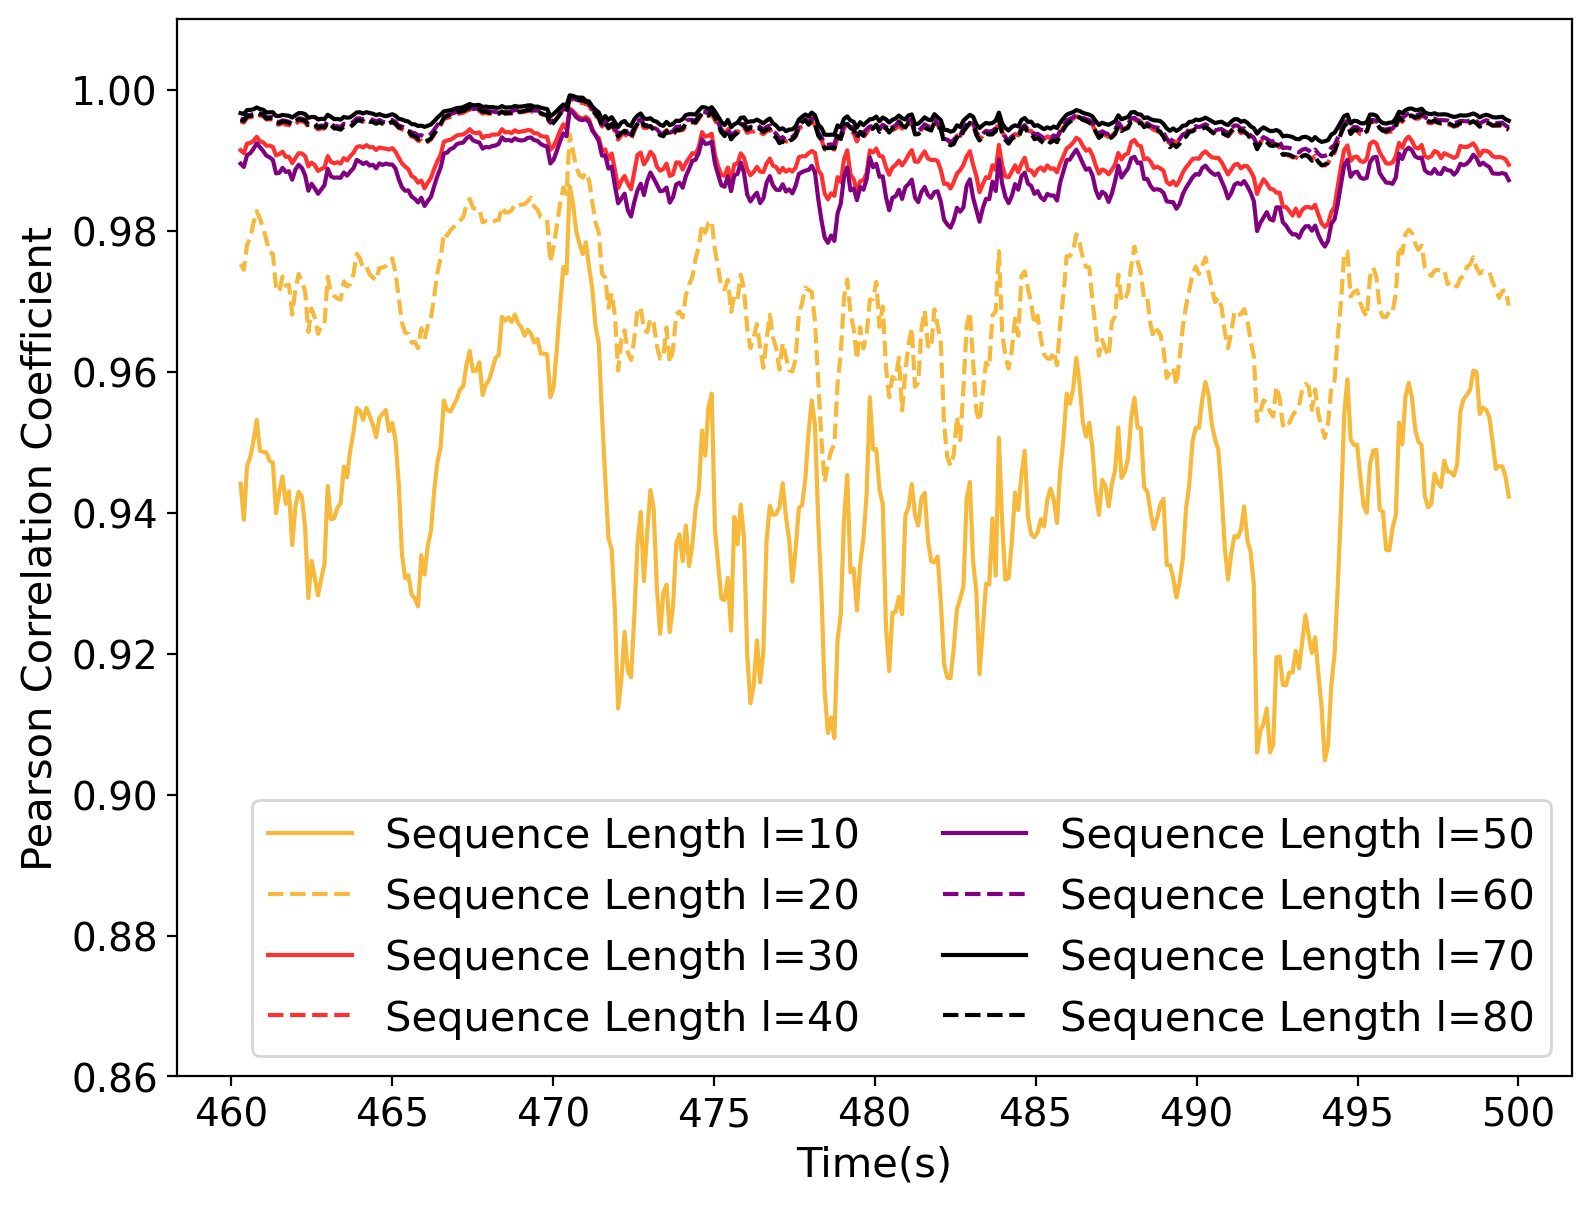

In [18]:
MP9.cc(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,0.86,'Velocity',460,2)


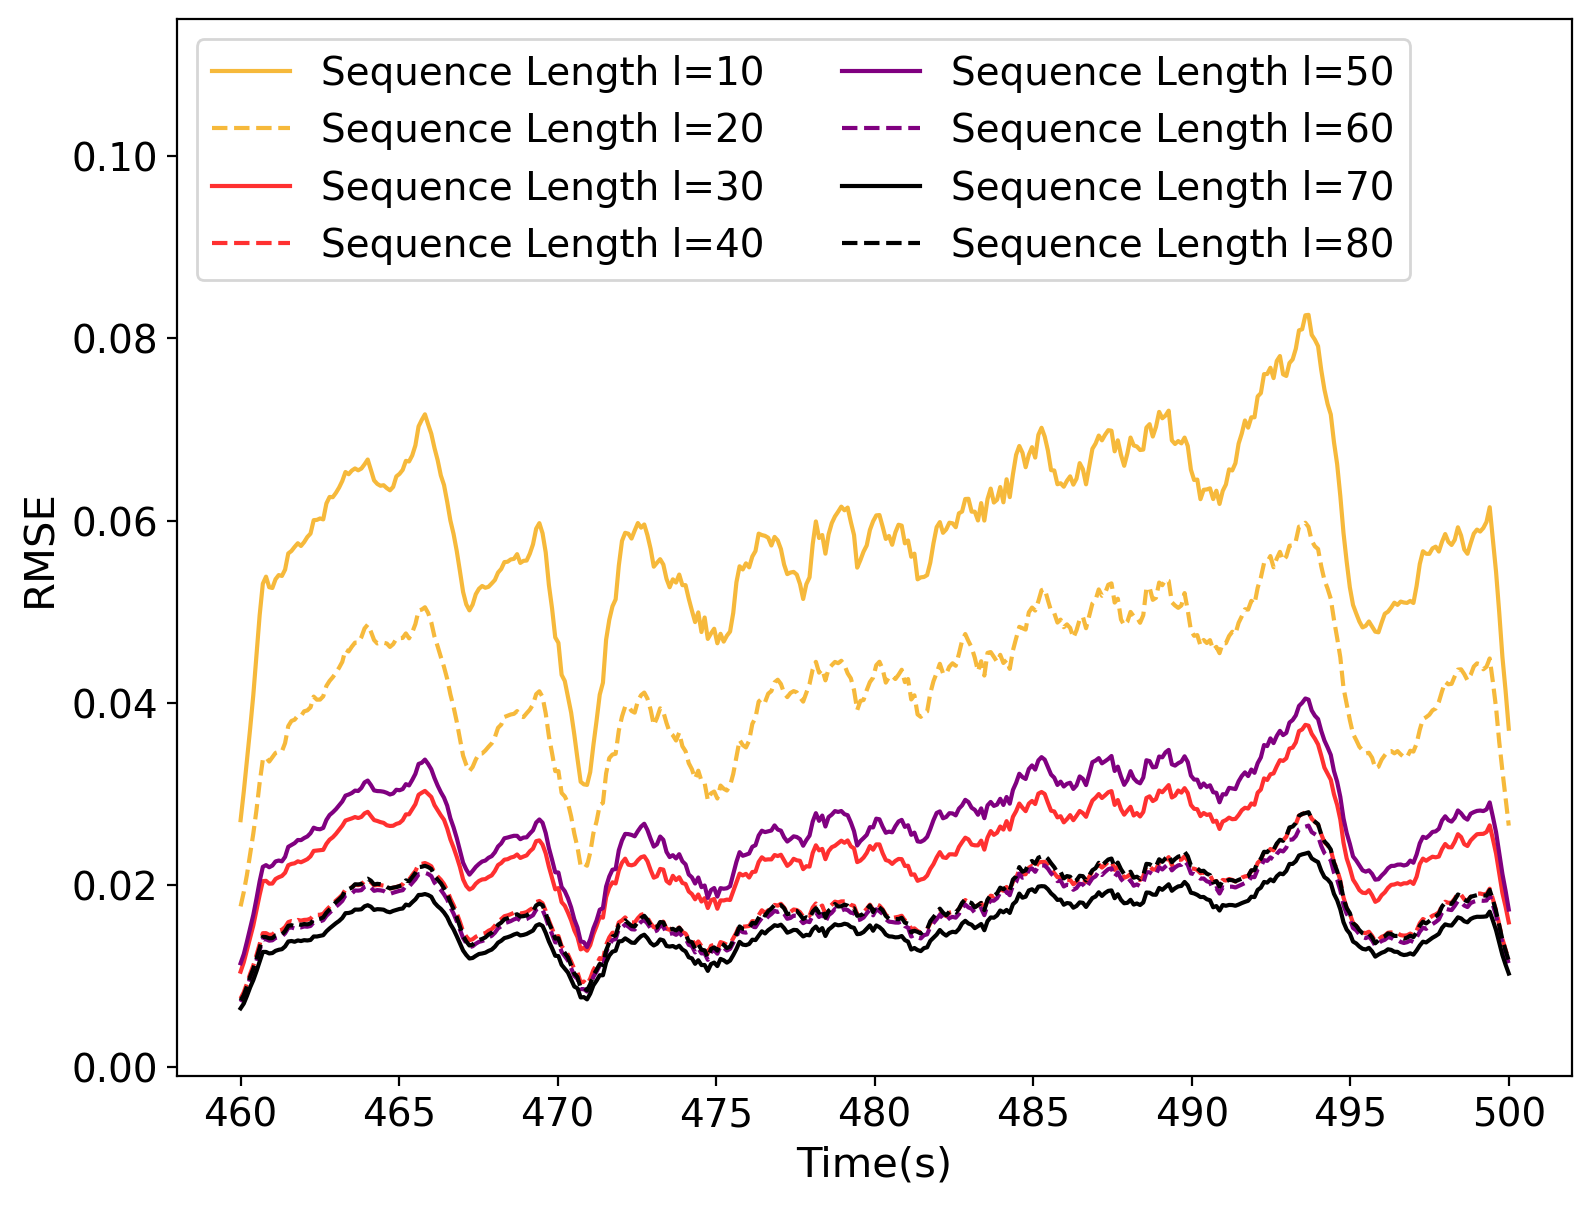

In [19]:
MP9.rmse_over_time(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,'Velocity', 0.115, 460,2)


In [25]:
#Comparison of prediction accuracy of three different models

import joblib
import pickle

encoding_dim =5# [5,10,45]
model_save_folder = './AE_Models_case1'#AE_Models_case1
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

print(np.load(open('./data/case1data/Velocity.npy', 'rb')).shape)
ori_data2=cal_Magnitude(np.load(open('./data/case1data/Velocity.npy', 'rb'))[4601:5001])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case1/ori_data2.pkl", "wb"))

seq_length=90

future_predictions_lstm_individual=(joblib.load(open("./Temp_data_Case1/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))).squeeze()
print(future_predictions_lstm_individual.shape)
rom_data_02=cal_Magnitude(recontruction(ae,future_predictions_lstm_individual[:,-400:]))
print(rom_data_02.shape)
pickle.dump(rom_data_02, open("./Temp_data_Case1/rom_data_02.pkl", "wb"))

y_pred=joblib.load(open("./Temp_data_Case1/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", 'rb'))
print(y_pred.shape)
rom_data_12=cal_Magnitude(recontruction(ae,y_pred[:,-400:]))#
print(rom_data_12.shape)
pickle.dump(rom_data_12, open("./Temp_data_Case1/rom_data_12.pkl", "wb"))

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_22=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case1/rom_data_22.pkl", "wb"))
#

(6002, 84180, 2)
(400, 84180)
(5, 400)
(400, 168360)
(400, 84180)
(5, 4601)
(400, 168360)
(400, 84180)
(5, 400)
(400, 168360)
(400, 84180)


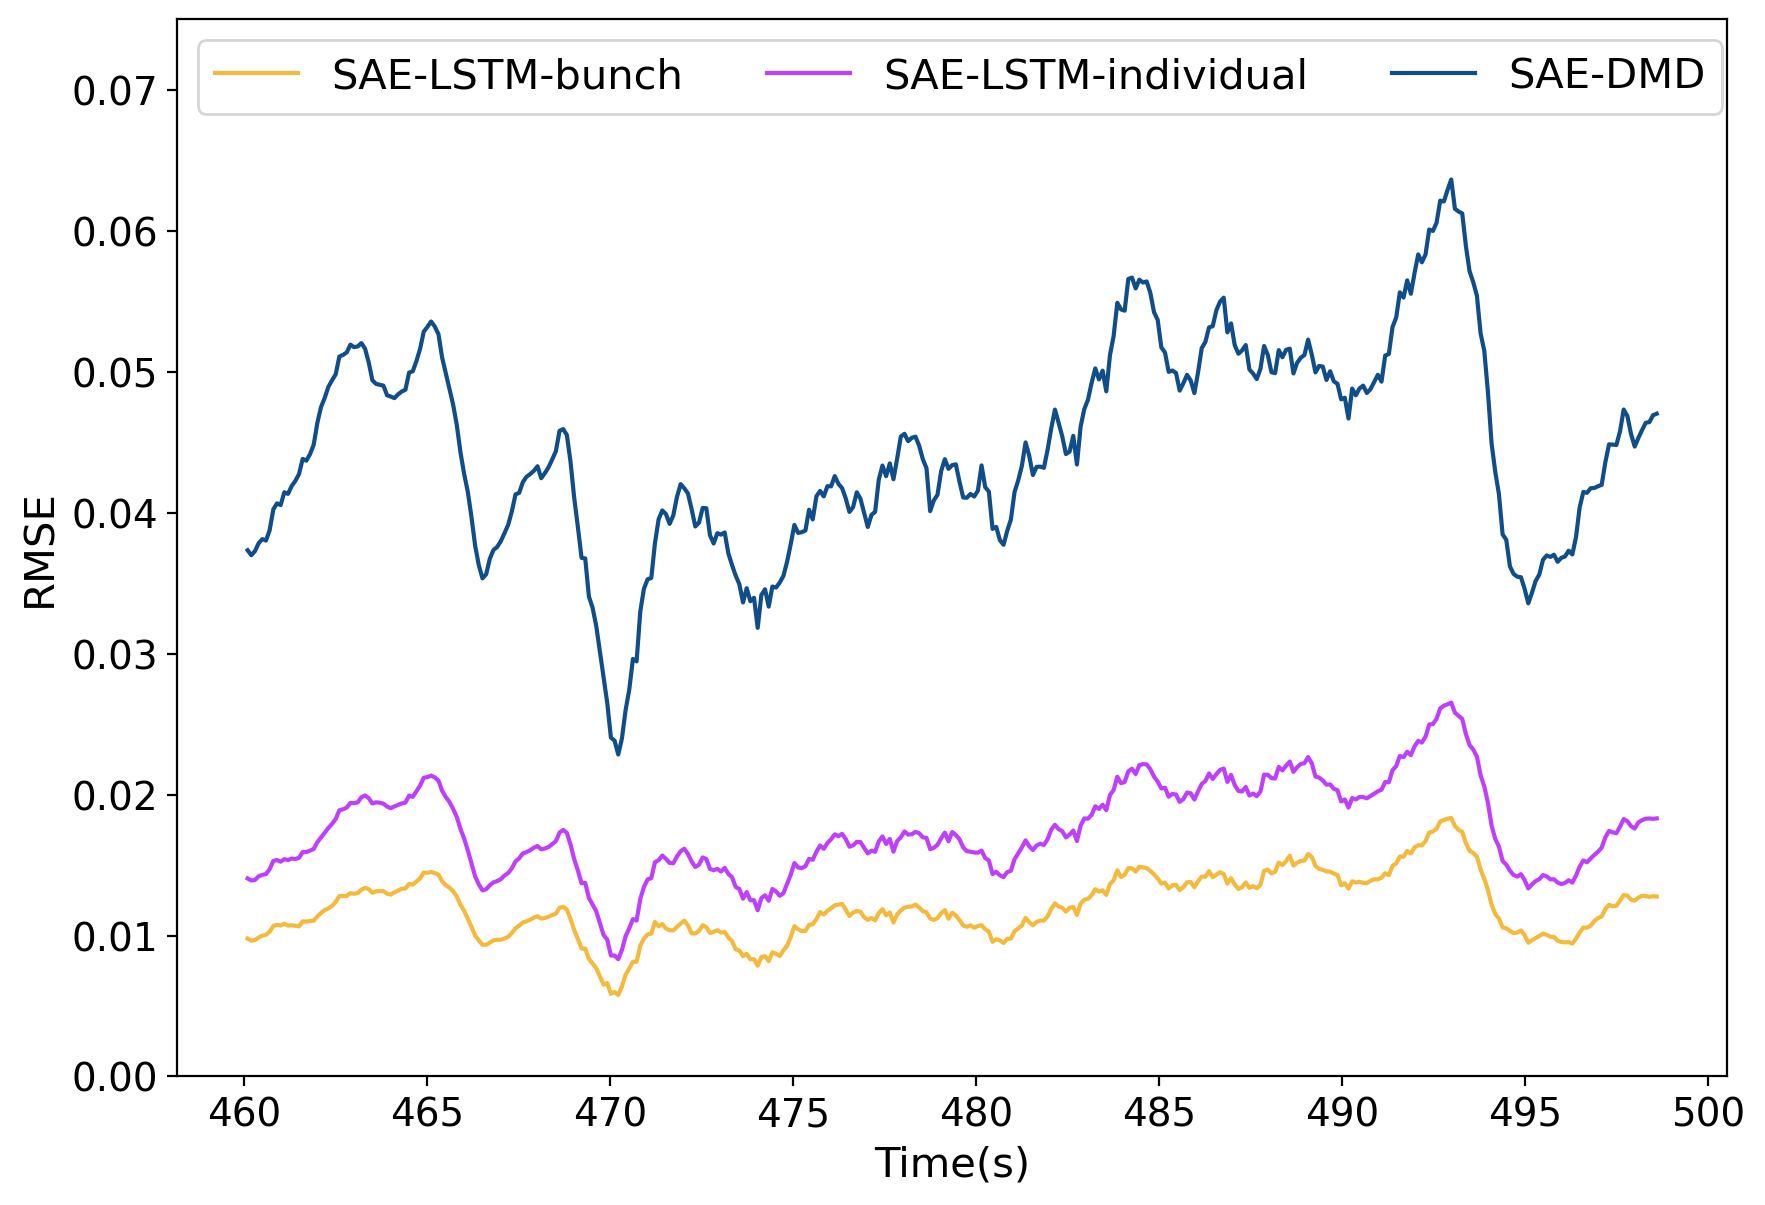

In [27]:
from dmd_machine import Model_Processing_4inputs_2 as MP4
ori_data2=joblib.load(open('./Temp_data_Case1/ori_data2.pkl', 'rb'))
rom_data_02=joblib.load(open('./Temp_data_Case1/rom_data_02.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case1/rom_data_12.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case1/rom_data_22.pkl', 'rb'))
MP4.rmse_over_time(ori_data2, rom_data_22, rom_data_02,rom_data_12,'Velocity',0.075,460,'upper left',3)

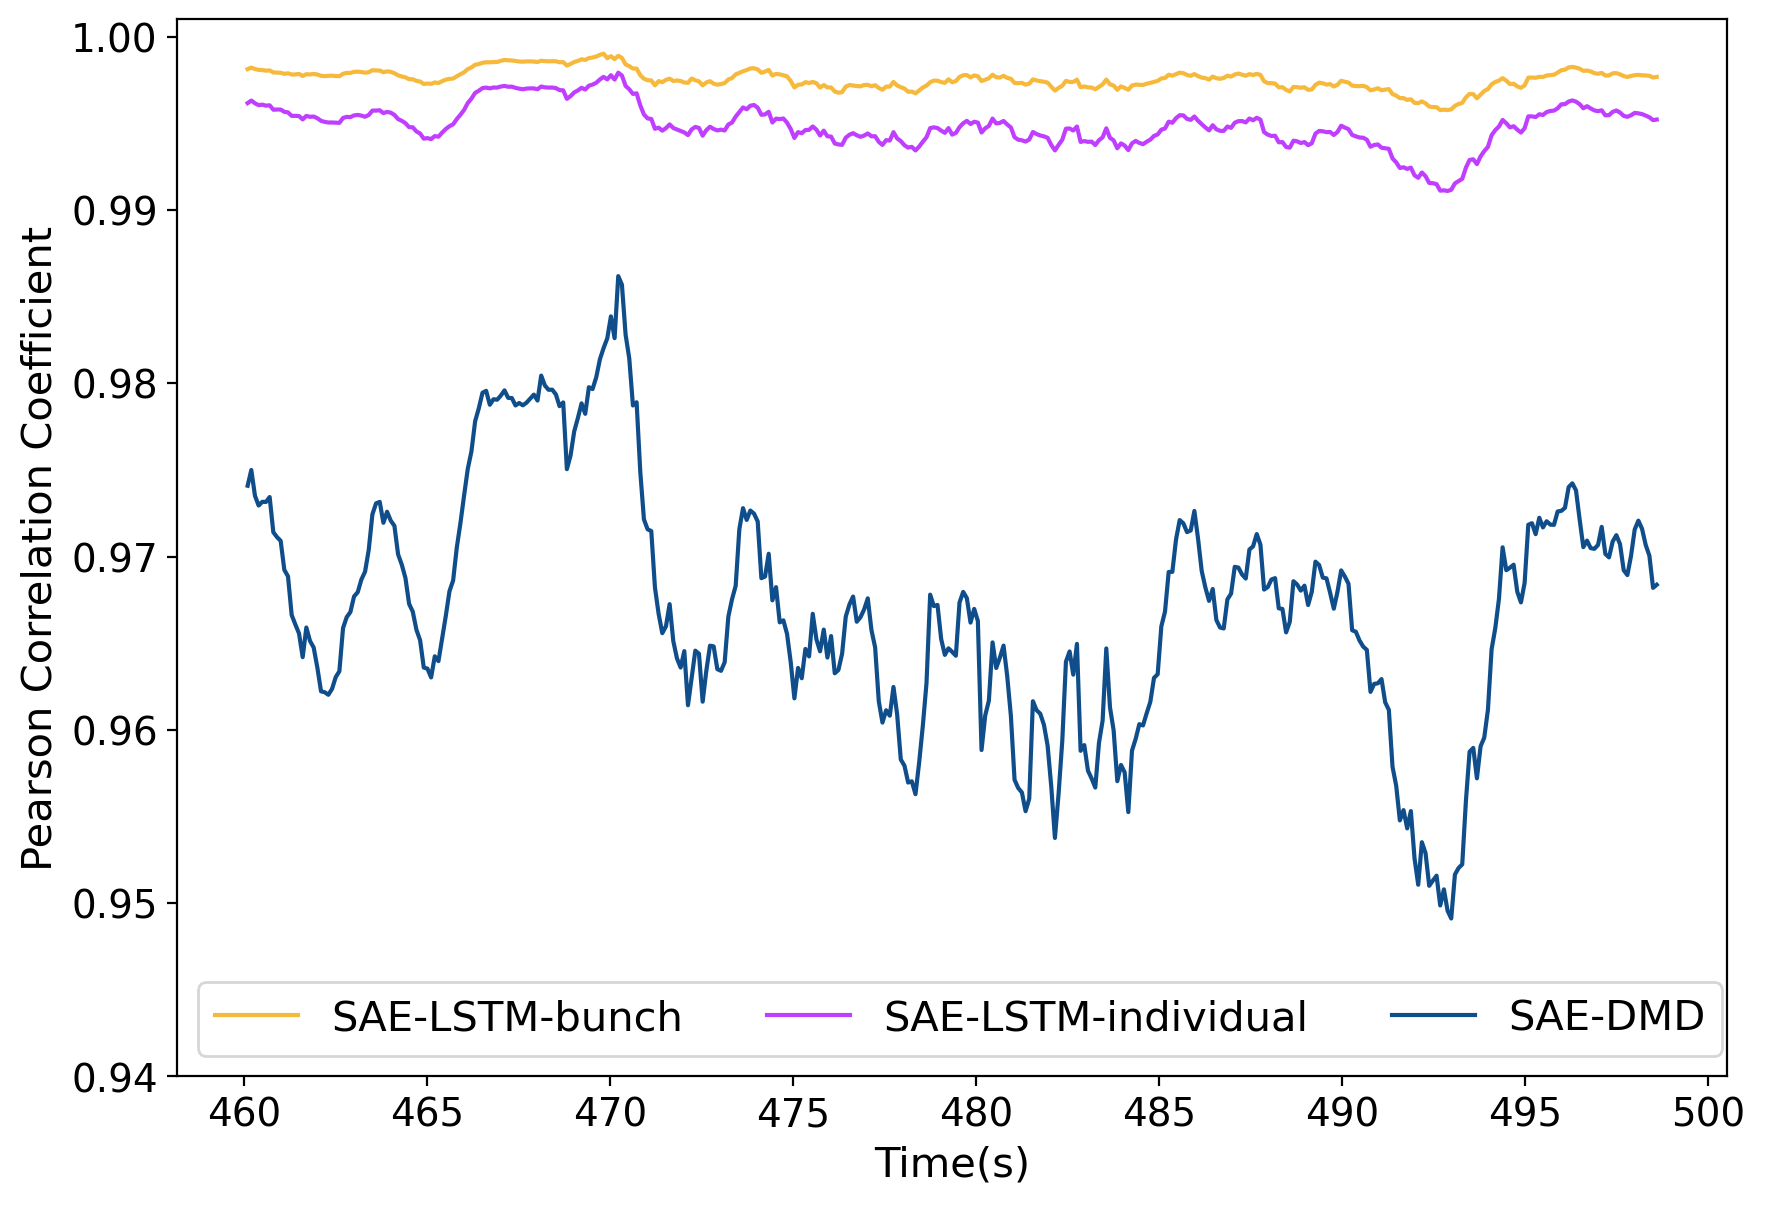

In [30]:
MP4.cc(ori_data2, rom_data_22, rom_data_02,rom_data_12,0.94,'Velocity',460,'lower left',3)

# ***Output***

In [ ]:
#Output the point over time of various-lengthe SAE-LSTM-bunch model, and the selected point ID is 8803 in the following code snippets.
print(np.load(open('./data/case1data/Velocity.npy', 'rb')).shape)#
ori_data2=np.load(open('./data/case1data/Velocity.npy', 'rb'))[4601:5001]
pickle.dump(ori_data2, open("./Temp_data_Case1/ori_data2.pkl", "wb"))
ori_data02=cal_Magnitude(ori_data2)# 
print(ori_data02.shape)
pickle.dump(ori_data02, open("./Temp_data_Case1/ori_data02.pkl", "wb"))

encoding_dim =5 #[5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_12=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_12, open("./Temp_data_Case1/rom_data_12.pkl", "wb"))
rom_data_22=cal_Magnitude(rom_data_12)
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case1/rom_data_22.pkl", "wb"))

encoding_dim =10 #[5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_32=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_32, open("./Temp_data_Case1/rom_data_32.pkl", "wb"))
rom_data_42=cal_Magnitude(rom_data_32)
print(rom_data_42.shape)
pickle.dump(rom_data_42, open("./Temp_data_Case1/rom_data_42.pkl", "wb"))

encoding_dim =45 #[5,10,45]
model_save_folder = './AE_Models_case1'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_52=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_52, open("./Temp_data_Case1/rom_data_52.pkl", "wb"))
rom_data_62=cal_Magnitude(rom_data_52)
print(rom_data_62.shape)
pickle.dump(rom_data_62, open("./Temp_data_Case1/rom_data_62.pkl", "wb"))


In [25]:
ori_data2=joblib.load(open("./Temp_data_Case1/ori_data2.pkl", 'rb'))
ori_data02=joblib.load(open("./Temp_data_Case1/ori_data02.pkl", 'rb'))

rom_data_12=joblib.load(open("./Temp_data_Case1/rom_data_12.pkl", 'rb'))
rom_data_22=joblib.load(open("./Temp_data_Case1/rom_data_22.pkl", 'rb'))

rom_data_32=joblib.load(open("./Temp_data_Case1/rom_data_32.pkl", 'rb'))
rom_data_42=joblib.load(open("./Temp_data_Case1/rom_data_42.pkl", 'rb'))

rom_data_52=joblib.load(open("./Temp_data_Case1/rom_data_52.pkl", 'rb'))
rom_data_62=joblib.load(open("./Temp_data_Case1/rom_data_62.pkl", 'rb'))


In [4]:
from dmd_machine import Model_Processing_4inputs_2 as MP4

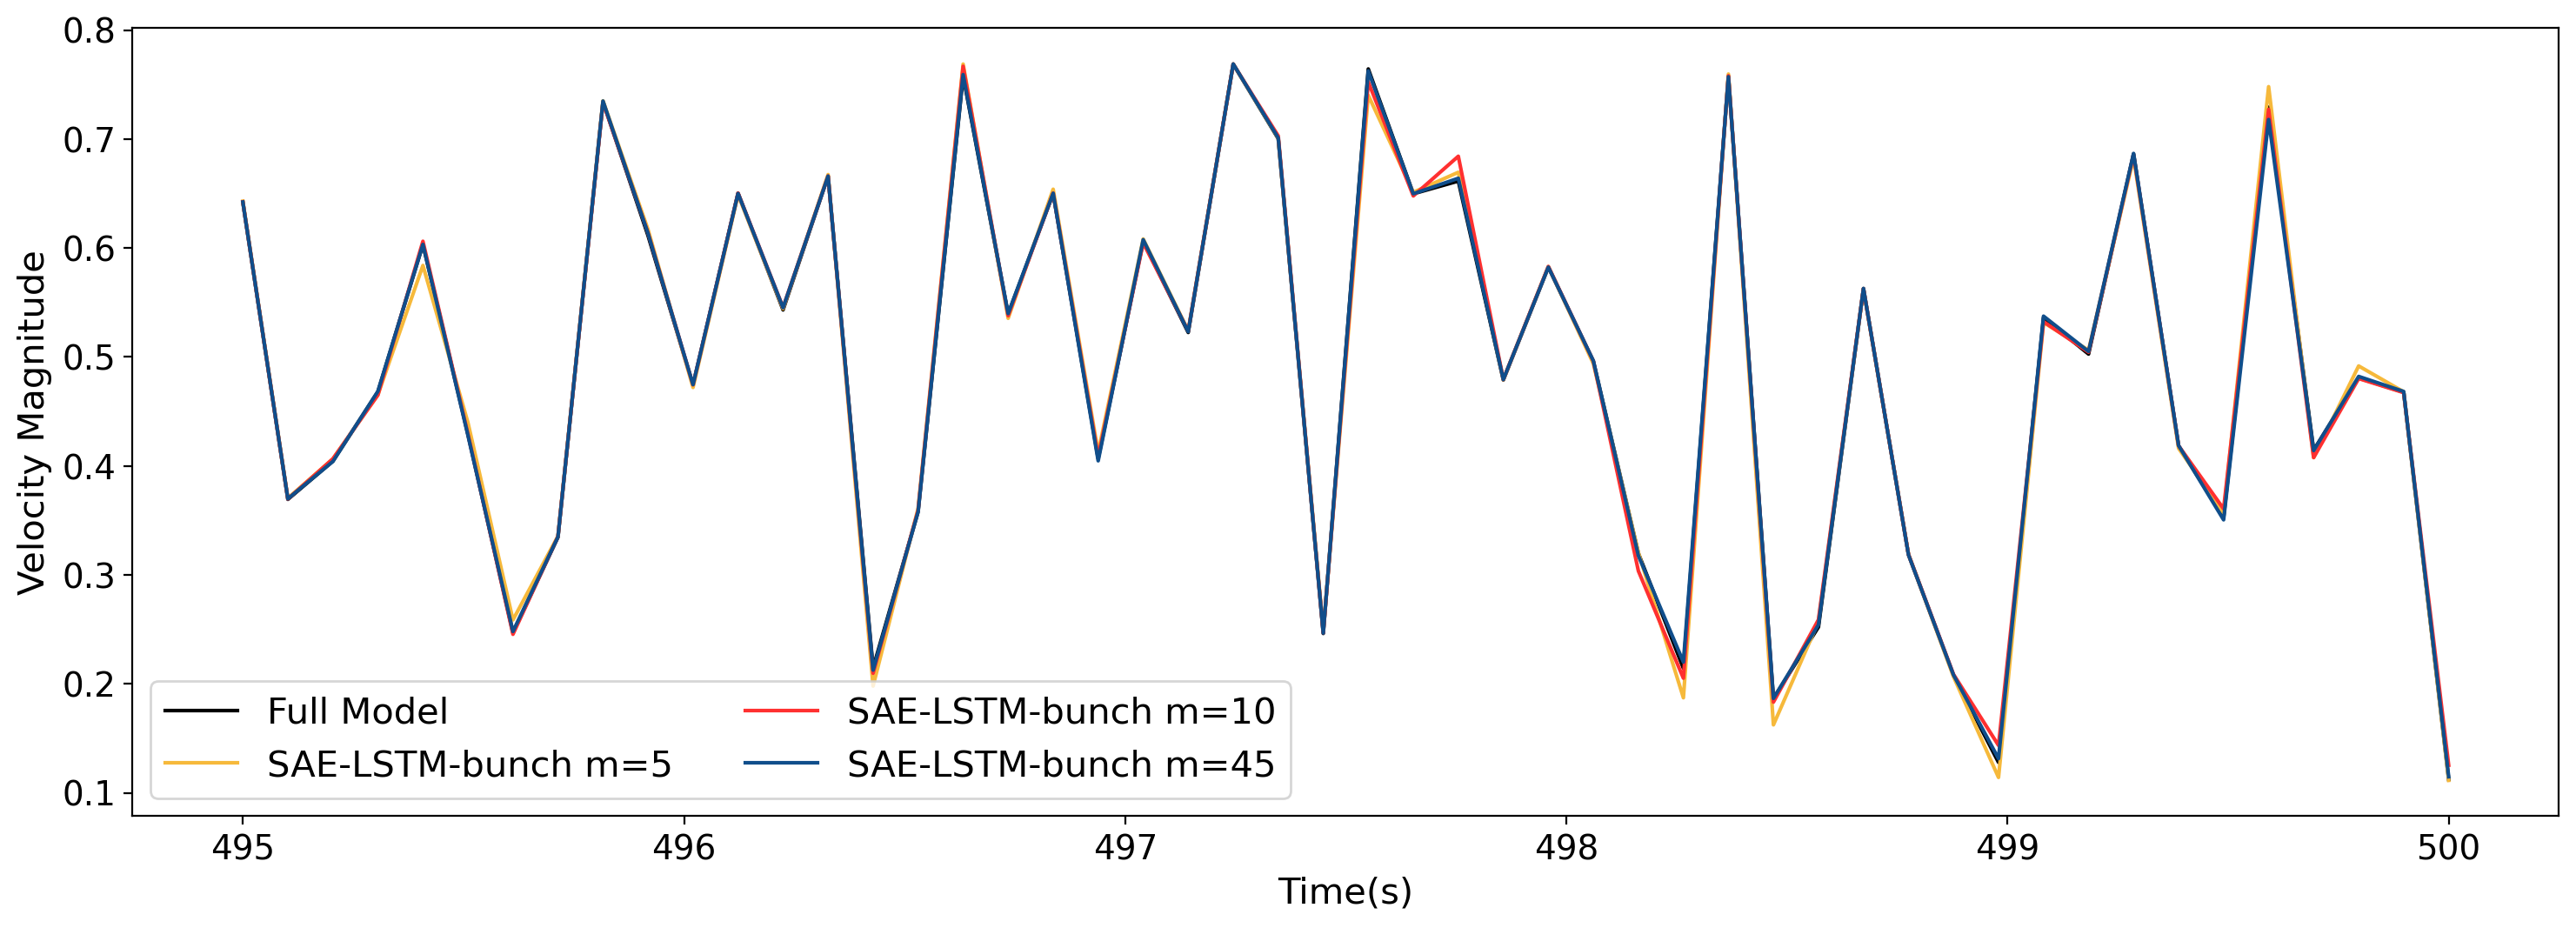

In [26]:
MP4.point_over_time(ori_data02[-50:], rom_data_22[-50:], rom_data_42[-50:], rom_data_62[-50:],8803,'Velocity',495,'lower left',2)


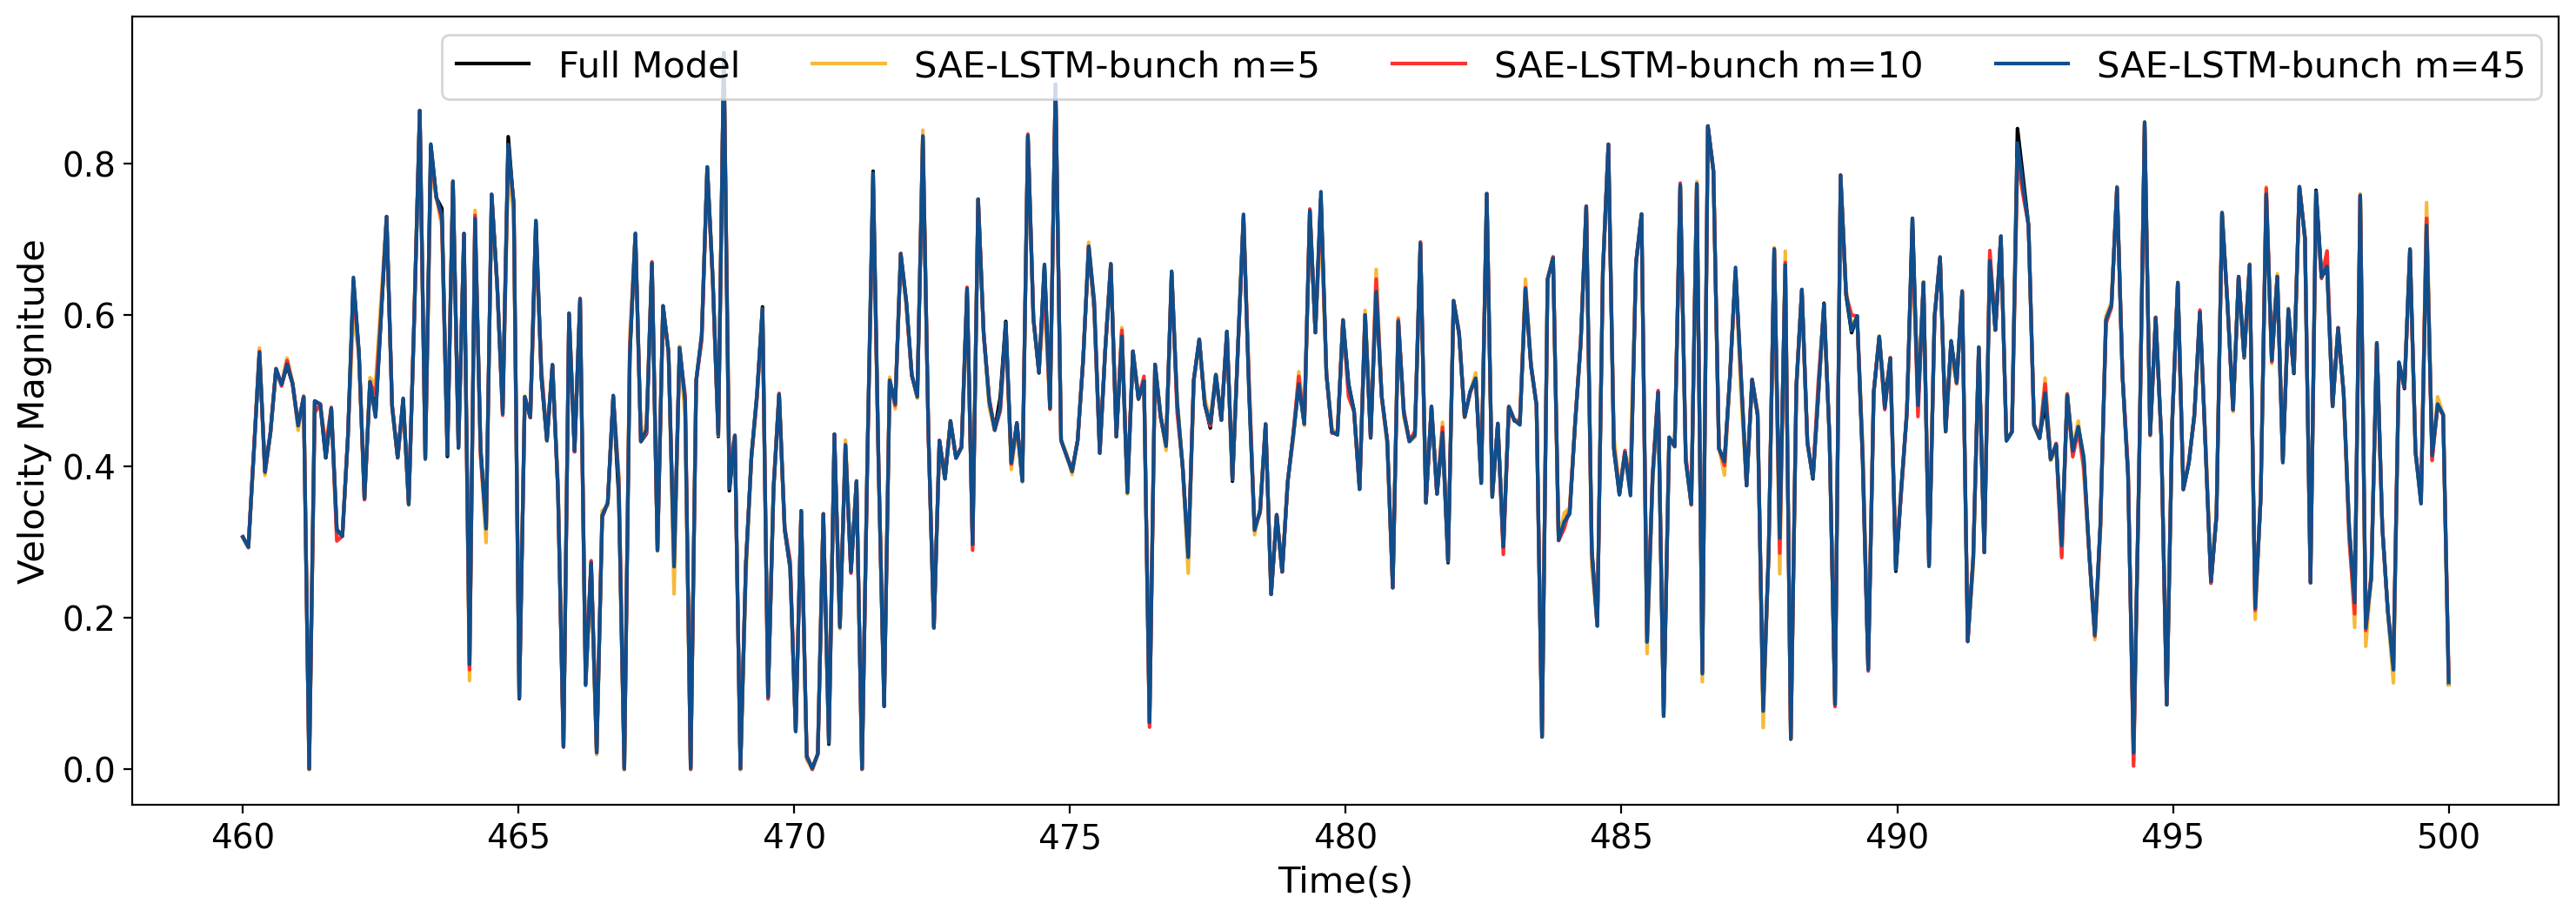

In [7]:
MP4.point_over_time(ori_data02, rom_data_22, rom_data_42, rom_data_62,8803,'Velocity',460,'upper right',4)


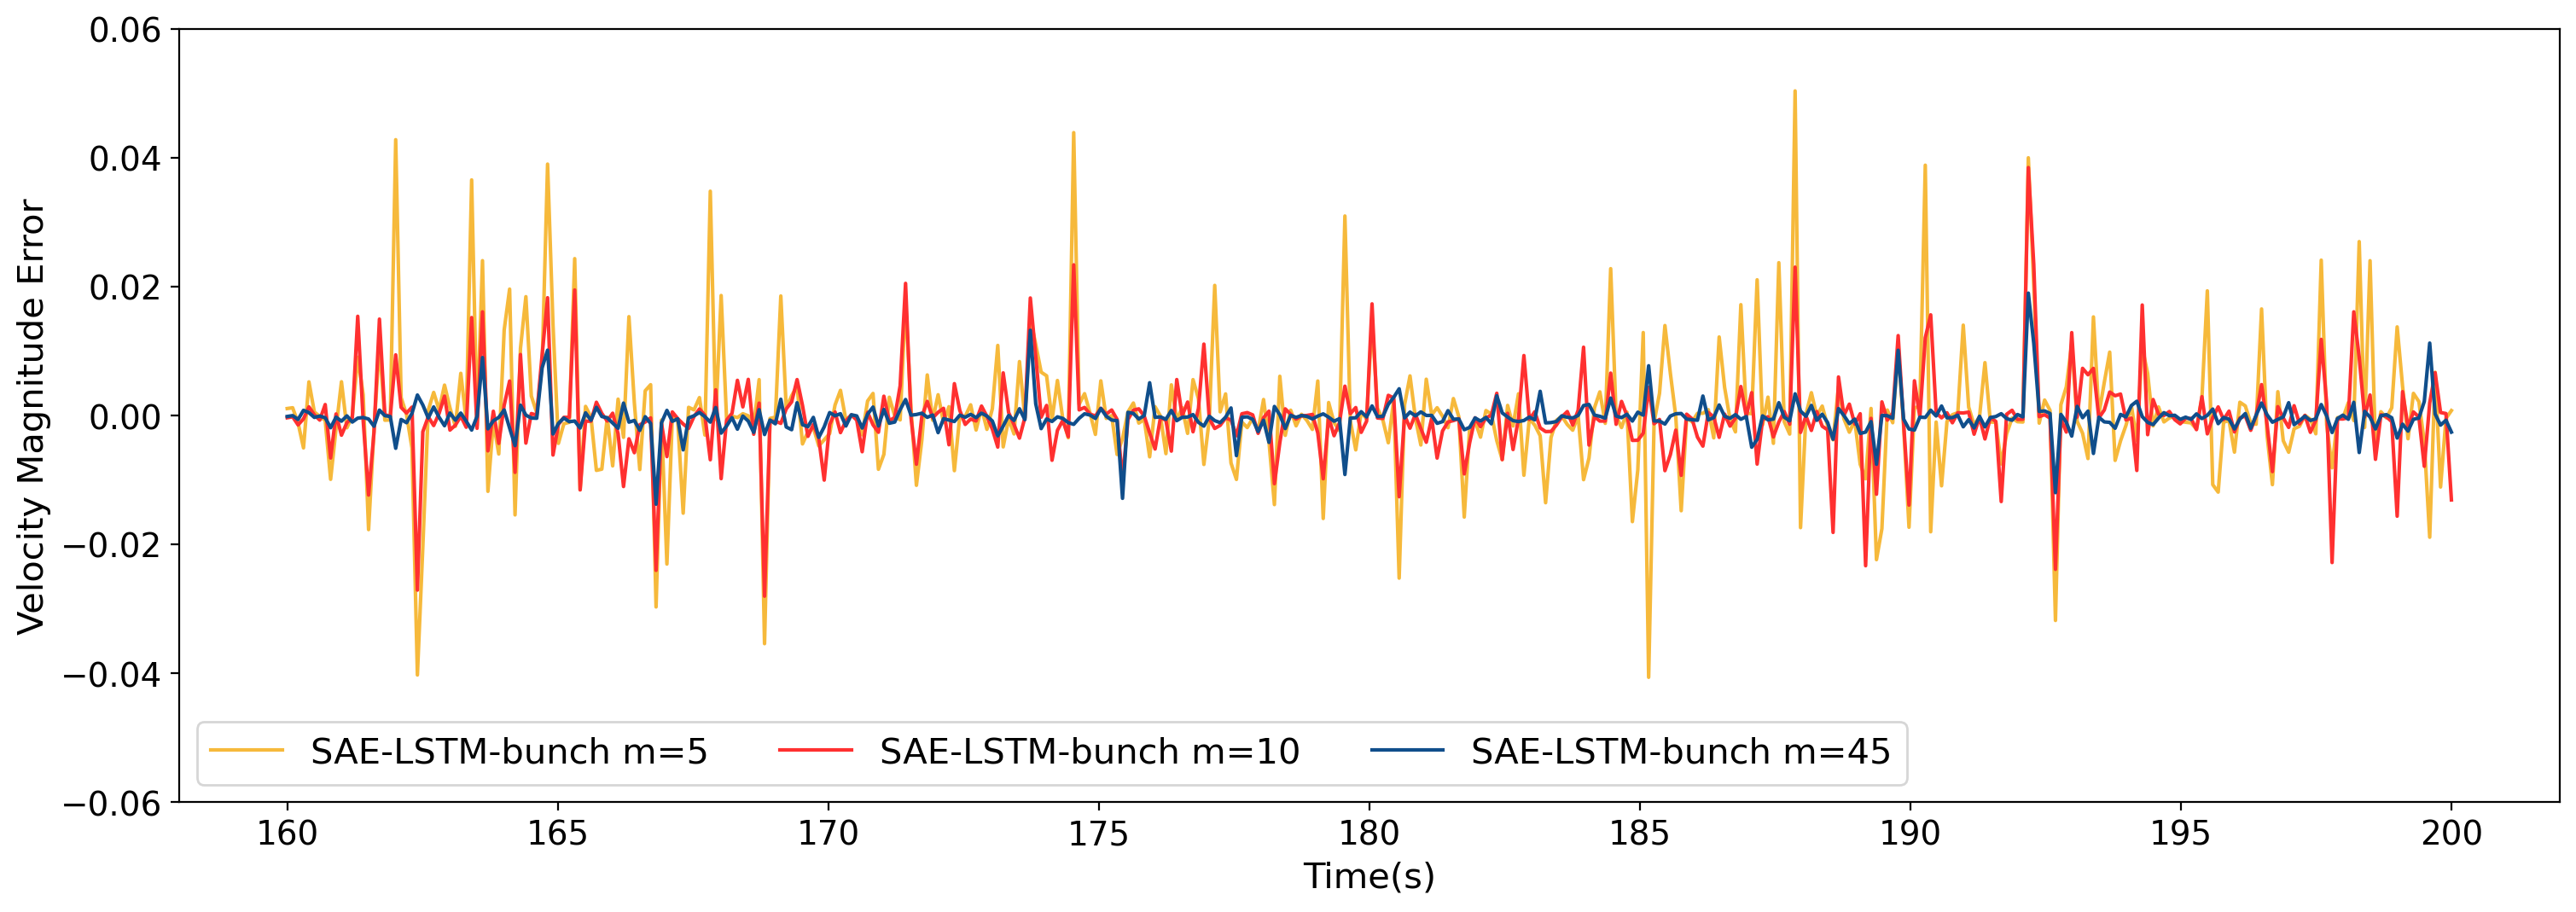

In [8]:
MP4.point_over_time_error(ori_data02, rom_data_22, rom_data_42, rom_data_62,8803,'Velocity',160,'lower left',3)

In [8]:
#Output the prediction results of SAE-LSTM-bunch model 
import numpy as np
import joblib
from dmd_machine import Model_Processing_4inputs_2 as MP
file_name = '/circle-2d-drag_'# name for each vtu file
field_name = 'Velocity2'# name of selected field


In [9]:
encoding_dim=5#[5,10,45]

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", 'rb')))
print(rom_data_1.shape)
MP.transform_vector(rom_data_1, rom_data_1.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_'+str(encoding_dim),file_name, field_name)



(400, 84180, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


In [11]:
rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(10)+".pkl", 'rb')))
print(rom_data_2.shape)
MP.transform_vector(rom_data_2, rom_data_2.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_'+str(10),file_name, field_name)

rom_data_3=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(45)+".pkl", 'rb')))
print(rom_data_3.shape)
MP.transform_vector(rom_data_3, rom_data_2.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_'+str(45),file_name, field_name)


(400, 84180, 2)
start to create the destination folder
start to store data as a new variable
transform succeed
(400, 84180, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


# ***Errors***

In [10]:
#Output the errors between the predition of SAE-LSTM-bunch model and ground true snapshots
import joblib
import math
import numpy as np
import pickle

ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[4601:5001]
print(ori_data.shape)

rom_data_0=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(5)+".pkl", 'rb')))

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(10)+".pkl", 'rb')))

rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case1/reconstructed_signals_lstm_bunch_"+str(45)+".pkl", 'rb')))

rom_error0=ori_data-rom_data_0
rom_error1=ori_data-rom_data_1
rom_error2=ori_data-rom_data_2


(400, 84180, 2)


In [12]:
import numpy as np
from dmd_machine import Model_Processing_4inputs_2 as MP
file_name = '/circle-2d-drag_'# name for each vtu file
field_name = 'Error'# name of selected field

MP.transform_vector(rom_error0, rom_data_0.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_error_'+str(5),file_name, field_name)
MP.transform_vector(rom_error1, rom_data_1.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_error_'+str(10),file_name, field_name)
MP.transform_vector(rom_error2, rom_data_2.shape[0], './data/case1data/VTU_forOutput', './Temp_data_Case1/LSTM_bunch_error_'+str(45),file_name, field_name)



start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
